- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack


from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.layers import Conv1D,GRU,TimeDistributed,MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling1D,ZeroPadding1D

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features=scaler.fit_transform(df_features)

# Select k-best features

In [5]:
from sklearn.feature_selection import SelectKBest
df_features = SelectKBest(k=12).fit_transform(df_features,mind_wandered_label)

In [6]:
participant_ids=participant_ids[:3300]

# Allknn undersampling

In [7]:
"""from imblearn.under_sampling import AllKNN
#df_features=df_features.values.reshape(-1, 1)
allknn = AllKNN()
df_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)"""

'from imblearn.under_sampling import AllKNN\n#df_features=df_features.values.reshape(-1, 1)\nallknn = AllKNN()\ndf_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)'

# SMOTEENN Oversampling

In [8]:
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)

In [9]:
mind_wandered_label.shape

(3300,)

# Data Reshape for conv1d

In [10]:
#df_features = df_features.to_numpy()
df_features=df_features.reshape((df_features.shape[0], df_features.shape[1], 1))
df_features.shape

(3300, 12, 1)

# AUROC

In [11]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

# Conv1d Model

In [12]:
def create_model(filters=64,kernel_size=5):
    model = Sequential([
    Conv1D(filters=filters, kernel_size=kernel_size,strides=8, activation='tanh',padding='same', input_shape=(df_features.shape[1], 1)),
    ZeroPadding1D(padding=1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
    optimizer=SGD(lr=0.001)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])
    return model

In [13]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=50, batch_size=32, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [14]:

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None


parameters = {
        #'scaling__type_of_scaling': ['standard'],
        #'outlier__outlier_threshold': [0.0, 3.0],
        #'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        'model__batch_size': [32, 48],#usually multiple of 8
        'model__epochs':[50,60],
        'model__filters':[8,16,32,64],
        'model__kernel_size':[3,5,7],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

# Estimator Pipeline
pipeline = Pipeline(
      [
        #('progress', GridSearchProgressHack(verbose=False)),
        #('scaling',  FeatureScalerTransformer()),
        #('outlier',  WinsorizationOutlierTransformer()),
        #('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        #('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
# Cross Validation Splitter
cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        #cv = 5,
        refit = 'roc_auc',
        verbose = 1)

search.fit(df_features, mind_wandered_label, groups=participant_ids)
#search.fit(df_features, mind_wandered_label)

df = pd.DataFrame(data=search.cv_results_)
    
    
if best_estimator is None:
    df_result = df
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    best_index = search.best_index_
else:
    df_result = df_result.append(df, ignore_index=True)
    if search.best_score_ > best_score:
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_  # todo this is only the index of this search

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.7124 - accuracy: 0.3534 - auc_roc: 0.3572
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.3561 - auc_roc: 0.3454
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.3409 - auc_roc: 0.3580
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.3643 - auc_roc: 0.3458
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7094 - accuracy: 0.3535 - auc_roc: 0.3668
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7099 - accuracy: 0.3419 - auc_roc: 0.3620
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.3413 - auc_roc: 0.3830
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.3418 - auc_roc: 0.3916
Epoch 9/50

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.7040 - accuracy: 0.4110 - auc_roc: 0.5394
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7028 - accuracy: 0.4264 - auc_roc: 0.3993
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.4328 - auc_roc: 0.4116
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.4342 - auc_roc: 0.3944
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.4551 - auc_roc: 0.4013
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4548 - auc_roc: 0.4040
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.4674 - auc_roc: 0.4220
Epoch 8/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.4718 - auc_roc: 0.3989
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6891 - accuracy: 0.5120 - auc_roc: 0.5992
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5295 - auc_roc: 0.5534
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5292 - auc_roc: 0.5438
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5365 - auc_roc: 0.5509
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5419 - auc_roc: 0.5667
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5655 - auc_roc: 0.5800
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5438 - auc_roc: 0.5545
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5469 - auc_roc: 0.5506
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7003 - accuracy: 0.4355 - auc_roc: 0.5799
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.4410 - auc_roc: 0.3499
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4749 - auc_roc: 0.3765
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4789 - auc_roc: 0.3546
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.4905 - auc_roc: 0.3581
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5034 - auc_roc: 0.3696
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5346 - auc_roc: 0.3916
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5282 - auc_roc: 0.3756
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7008 - accuracy: 0.3801 - auc_roc: 0.5800
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.3948 - auc_roc: 0.5387
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4131 - auc_roc: 0.5439
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.4261 - auc_roc: 0.5532
Epoch 5/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.4375 - auc_roc: 0.5384
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4530 - auc_roc: 0.5619
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4763 - auc_roc: 0.5590
Epoch 8/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.4973 - auc_roc: 0.5596
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6891 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6886 - accuracy: 0.5685 - auc_roc: 0.6099
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5649 - auc_roc: 0.5584
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.6030 - auc_roc: 0.5824
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5989 - auc_roc: 0.5849
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5926 - auc_roc: 0.5858
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6220 - auc_roc: 0.6053
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.6168 - auc_roc: 0.6133
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.6211 - auc_roc: 0.6047
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6751 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6901 - accuracy: 0.4973 - auc_roc: 0.6272
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5136 - auc_roc: 0.5257
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5092 - auc_roc: 0.5235
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5287 - auc_roc: 0.5272
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5346 - auc_roc: 0.5348
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5563 - auc_roc: 0.5459
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5448 - auc_roc: 0.5323
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5748 - auc_roc: 0.5503
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6786 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6823 - accuracy: 0.5138 - auc_roc: 0.6267
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5256 - auc_roc: 0.5597
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5565 - auc_roc: 0.5912
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5652 - auc_roc: 0.5989
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.5676 - auc_roc: 0.5845
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.5824 - auc_roc: 0.6061
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5759 - auc_roc: 0.5823
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5933 - auc_roc: 0.6096
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 4ms/step - loss: 0.7011 - accuracy: 0.4762 - auc_roc: 0.5932
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.4947 - auc_roc: 0.3847
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5011 - auc_roc: 0.3999
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4856 - auc_roc: 0.3635
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5076 - auc_roc: 0.3895
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5132 - auc_roc: 0.4002
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5147 - auc_roc: 0.3907
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5198 - auc_roc: 0.4095
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7029 - accuracy: 0.4204 - auc_roc: 0.5691
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4501 - auc_roc: 0.4386
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.4658 - auc_roc: 0.4327
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.4905 - auc_roc: 0.4482
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4970 - auc_roc: 0.4466
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5276 - auc_roc: 0.4624
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5424 - auc_roc: 0.4780
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5537 - auc_roc: 0.4884
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6891 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.3773 - auc_roc: 0.6196
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7011 - accuracy: 0.4027 - auc_roc: 0.5652
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.4184 - auc_roc: 0.6019
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.4370 - auc_roc: 0.5869
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5109 - auc_roc: 0.6172
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5331 - auc_roc: 0.6126
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5698 - auc_roc: 0.6471
Epoch 8/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5750 - auc_roc: 0.6441
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7129 - accuracy: 0.3314 - auc_roc: 0.5863
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.3510 - auc_roc: 0.2939
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7101 - accuracy: 0.3406 - auc_roc: 0.2762
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.3575 - auc_roc: 0.2976
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7059 - accuracy: 0.3743 - auc_roc: 0.3036
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7049 - accuracy: 0.3661 - auc_roc: 0.2995
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.3548 - auc_roc: 0.2995
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.3878 - auc_roc: 0.3275
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7006 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6997 - accuracy: 0.4267 - auc_roc: 0.6388
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.4270 - auc_roc: 0.5264
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.4548 - auc_roc: 0.5534
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.4607 - auc_roc: 0.5612
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.4719 - auc_roc: 0.5353
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5099 - auc_roc: 0.5687
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5185 - auc_roc: 0.5781
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5289 - auc_roc: 0.5726
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6974 - accuracy: 0.5104 - auc_roc: 0.6087
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5177 - auc_roc: 0.4159
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5269 - auc_roc: 0.4152
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5507 - auc_roc: 0.4398
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5716 - auc_roc: 0.4342
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5674 - auc_roc: 0.4358
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5550 - auc_roc: 0.4348
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5720 - auc_roc: 0.4672
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6858 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6837 - accuracy: 0.6066 - auc_roc: 0.5922
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.6328 - auc_roc: 0.4769
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6690 - auc_roc: 0.5361
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6576 - auc_roc: 0.5020
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.6577 - auc_roc: 0.5185
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6854 - auc_roc: 0.5274
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6824 - auc_roc: 0.5555
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6943 - auc_roc: 0.5727
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6604 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.5170 - auc_roc: 0.6204
Epoch 2/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5176 - auc_roc: 0.4146
Epoch 3/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5559 - auc_roc: 0.4330
Epoch 4/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5590 - auc_roc: 0.4265
Epoch 5/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5488 - auc_roc: 0.4353
Epoch 6/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5709 - auc_roc: 0.4484
Epoch 7/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5772 - auc_roc: 0.4564
Epoch 8/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5860 - auc_roc: 0.4548
Epoch 9/50
83/83 [==============================] - 0s 2ms/step - loss: 0.6830 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7121 - accuracy: 0.3739 - auc_roc: 0.6048
Epoch 2/50
83/83 [==============================] - 0s 2ms/step - loss: 0.7126 - accuracy: 0.3714 - auc_roc: 0.5248
Epoch 3/50
83/83 [==============================] - 0s 2ms/step - loss: 0.7161 - accuracy: 0.3439 - auc_roc: 0.5243
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.3755 - auc_roc: 0.5275
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.3724 - auc_roc: 0.5096
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.3909 - auc_roc: 0.5352
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.3997 - auc_roc: 0.5458
Epoch 8/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.4259 - auc_roc: 0.5366
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7050 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 4ms/step - loss: 0.7072 - accuracy: 0.4442 - auc_roc: 0.6311
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.4713 - auc_roc: 0.4614
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.4696 - auc_roc: 0.4452
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.4864 - auc_roc: 0.4709
Epoch 5/50
83/83 [==============================] - 0s 2ms/step - loss: 0.7021 - accuracy: 0.4803 - auc_roc: 0.4712
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.4824 - auc_roc: 0.4648
Epoch 7/50
83/83 [==============================] - 0s 2ms/step - loss: 0.7005 - accuracy: 0.4956 - auc_roc: 0.4796
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.4894 - auc_roc: 0.4839
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7002 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6970 - accuracy: 0.4534 - auc_roc: 0.6144
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4605 - auc_roc: 0.4824
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4526 - auc_roc: 0.4772
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4591 - auc_roc: 0.4819
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.4481 - auc_roc: 0.4687
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.4886 - auc_roc: 0.4992
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4909 - auc_roc: 0.5088
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.4951 - auc_roc: 0.5021
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7102 - accuracy: 0.4147 - auc_roc: 0.5873
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.4291 - auc_roc: 0.5417
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.4188 - auc_roc: 0.5256
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.4220 - auc_roc: 0.5122
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.4380 - auc_roc: 0.5090
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.4604 - auc_roc: 0.5172
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.4610 - auc_roc: 0.5212
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4838 - auc_roc: 0.5217
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6966 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6895 - accuracy: 0.4943 - auc_roc: 0.6147
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4898 - auc_roc: 0.4117
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5218 - auc_roc: 0.4423
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5168 - auc_roc: 0.4193
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5280 - auc_roc: 0.4535
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5493 - auc_roc: 0.4677
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5239 - auc_roc: 0.4494
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5724 - auc_roc: 0.4575
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6730 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5457 - auc_roc: 0.6057
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5545 - auc_roc: 0.4541
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5558 - auc_roc: 0.4578
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5811 - auc_roc: 0.4937
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.6261 - auc_roc: 0.5018
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.6231 - auc_roc: 0.5201
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.6487 - auc_roc: 0.5510
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6313 - auc_roc: 0.5463
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6774 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6867 - accuracy: 0.5239 - auc_roc: 0.6518
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5038 - auc_roc: 0.4682
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5282 - auc_roc: 0.4958
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5249 - auc_roc: 0.4958
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5330 - auc_roc: 0.4972
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5248 - auc_roc: 0.4996
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5398 - auc_roc: 0.4991
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5345 - auc_roc: 0.5028
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6789 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6479 - accuracy: 0.6584 - auc_roc: 0.6520
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6499 - auc_roc: 0.6809
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6595 - auc_roc: 0.6832
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6579 - auc_roc: 0.6745
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6455 - auc_roc: 0.6704
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6465 - auc_roc: 0.6831
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6477 - auc_roc: 0.6793
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6417 - auc_roc: 0.6704
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6342 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 5ms/step - loss: 0.6952 - accuracy: 0.4607 - auc_roc: 0.5980
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4716 - auc_roc: 0.4262
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4803 - auc_roc: 0.4080
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5201 - auc_roc: 0.4313
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5391 - auc_roc: 0.4351
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.5502 - auc_roc: 0.4312
Epoch 7/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5845 - auc_roc: 0.4653
Epoch 8/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5827 - auc_roc: 0.4527
Epoch 9/50
83/83 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6914 - accuracy: 0.5249 - auc_roc: 0.6205
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5576 - auc_roc: 0.4579
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5859 - auc_roc: 0.4859
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5988 - auc_roc: 0.4972
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.6110 - auc_roc: 0.5281
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.6248 - auc_roc: 0.5363
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6524 - auc_roc: 0.5656
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.6447 - auc_roc: 0.5690
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6764 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5862 - auc_roc: 0.6475
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5967 - auc_roc: 0.4624
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.6049 - auc_roc: 0.4439
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.6459 - auc_roc: 0.4865
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6111 - auc_roc: 0.5009
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.6417 - auc_roc: 0.5153
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6240 - auc_roc: 0.5107
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.6251 - auc_roc: 0.5365
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6677 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6944 - accuracy: 0.5107 - auc_roc: 0.6316
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5346 - auc_roc: 0.4681
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5194 - auc_roc: 0.4535
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5332 - auc_roc: 0.4697
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5562 - auc_roc: 0.4986
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5663 - auc_roc: 0.5008
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5598 - auc_roc: 0.5147
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5693 - auc_roc: 0.5051
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6839 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.7134 - accuracy: 0.3617 - auc_roc: 0.5834
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.3732 - auc_roc: 0.3586
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.3679 - auc_roc: 0.3701
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.3586 - auc_roc: 0.3654
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.3422 - auc_roc: 0.3654
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7089 - accuracy: 0.3569 - auc_roc: 0.3779
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.3756 - auc_roc: 0.3991
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.3895 - auc_roc: 0.4218
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6704 - accuracy: 0.6365 - auc_roc: 0.6507
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.6405 - auc_roc: 0.6227
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6443 - auc_roc: 0.6442
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6551 - auc_roc: 0.6431
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.6426 - auc_roc: 0.6281
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6602 - auc_roc: 0.6520
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6547 - auc_roc: 0.6656
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6687 - auc_roc: 0.6847
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6440 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6864 - accuracy: 0.5721 - auc_roc: 0.6477
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5962 - auc_roc: 0.5810
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.6203 - auc_roc: 0.5971
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6079 - auc_roc: 0.5831
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.6276 - auc_roc: 0.6143
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6327 - auc_roc: 0.6318
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.6287 - auc_roc: 0.6389
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.6332 - auc_roc: 0.6316
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6620 - accuracy: 0.6413 - auc_roc: 0.6733
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6318 - auc_roc: 0.6163
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6307 - auc_roc: 0.6305
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6425 - auc_roc: 0.6519
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6414 - auc_roc: 0.6668
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6342 - auc_roc: 0.6483
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6177 - auc_roc: 0.6486
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6394 - auc_roc: 0.6632
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6505 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6963 - accuracy: 0.4662 - auc_roc: 0.6211
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.4564 - auc_roc: 0.4437
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4861 - auc_roc: 0.4687
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4920 - auc_roc: 0.4726
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4849 - auc_roc: 0.4748
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4938 - auc_roc: 0.4752
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5116 - auc_roc: 0.5085
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5293 - auc_roc: 0.5248
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 4ms/step - loss: 0.6986 - accuracy: 0.4545 - auc_roc: 0.6075
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.4602 - auc_roc: 0.5943
Epoch 3/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4689 - auc_roc: 0.6150
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.4969 - auc_roc: 0.6141
Epoch 5/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4820 - auc_roc: 0.6064
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5135 - auc_roc: 0.6152
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5166 - auc_roc: 0.6097
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5296 - auc_roc: 0.6223
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7126 - accuracy: 0.3701 - auc_roc: 0.5782
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.3921 - auc_roc: 0.3847
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.4117 - auc_roc: 0.4058
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.4152 - auc_roc: 0.4105
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.4378 - auc_roc: 0.4281
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.4436 - auc_roc: 0.4293
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4557 - auc_roc: 0.4369
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4630 - auc_roc: 0.4226
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6964 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.7088 - accuracy: 0.3376 - auc_roc: 0.5948
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.3521 - auc_roc: 0.3096
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.3701 - auc_roc: 0.3215
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.3820 - auc_roc: 0.3329
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.3922 - auc_roc: 0.3351
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.4043 - auc_roc: 0.3486
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.3974 - auc_roc: 0.3384
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4390 - auc_roc: 0.3654
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 4ms/step - loss: 0.6863 - accuracy: 0.5918 - auc_roc: 0.6043
Epoch 2/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6856 - accuracy: 0.5996 - auc_roc: 0.5063
Epoch 3/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.6118 - auc_roc: 0.5506
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.6083 - auc_roc: 0.5570
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.6206 - auc_roc: 0.5711
Epoch 6/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.6117 - auc_roc: 0.5855
Epoch 7/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6760 - accuracy: 0.6269 - auc_roc: 0.5981
Epoch 8/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.6356 - auc_roc: 0.6187
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.7064 - accuracy: 0.4202 - auc_roc: 0.6146
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.4429 - auc_roc: 0.4489
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.4649 - auc_roc: 0.4681
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.4616 - auc_roc: 0.4588
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.4821 - auc_roc: 0.4781
Epoch 6/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.4686 - auc_roc: 0.4621
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6987 - accuracy: 0.4846 - auc_roc: 0.4815
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.4976 - auc_roc: 0.4815
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7032 - accuracy: 0.4070 - auc_roc: 0.6047
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.4202 - auc_roc: 0.4132
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.4376 - auc_roc: 0.4092
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4441 - auc_roc: 0.4264
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.4309 - auc_roc: 0.4100
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.4435 - auc_roc: 0.4392
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.4742 - auc_roc: 0.4622
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4963 - auc_roc: 0.4977
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6917 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6789 - accuracy: 0.6291 - auc_roc: 0.6289
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.6486 - auc_roc: 0.5974
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.6481 - auc_roc: 0.5888
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.6509 - auc_roc: 0.6205
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6578 - auc_roc: 0.6417
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6639 - auc_roc: 0.6420
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6730 - auc_roc: 0.6385
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6815 - auc_roc: 0.6680
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6566 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.4523 - auc_roc: 0.6186
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.4951 - auc_roc: 0.4282
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5143 - auc_roc: 0.4614
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5481 - auc_roc: 0.4837
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5870 - auc_roc: 0.4963
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.6121 - auc_roc: 0.5436
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.6326 - auc_roc: 0.6084
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6549 - auc_roc: 0.6280
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.7031 - accuracy: 0.3669 - auc_roc: 0.6165
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.3779 - auc_roc: 0.3625
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.3934 - auc_roc: 0.3608
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4074 - auc_roc: 0.3699
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4220 - auc_roc: 0.3689
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4798 - auc_roc: 0.4265
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5094 - auc_roc: 0.4313
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5237 - auc_roc: 0.4604
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4783 - auc_roc: 0.6509
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.4832 - auc_roc: 0.4924
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5021 - auc_roc: 0.5112
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5023 - auc_roc: 0.5147
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5212 - auc_roc: 0.5294
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5659 - auc_roc: 0.5838
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5431 - auc_roc: 0.5625
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5566 - auc_roc: 0.5725
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6760 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6903 - accuracy: 0.5724 - auc_roc: 0.6597
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.6019 - auc_roc: 0.4557
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.6183 - auc_roc: 0.5068
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.6311 - auc_roc: 0.5244
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.6338 - auc_roc: 0.5406
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.6373 - auc_roc: 0.5695
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.6394 - auc_roc: 0.5655
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6404 - auc_roc: 0.6100
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6748 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6779 - accuracy: 0.6230 - auc_roc: 0.6343
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6411 - auc_roc: 0.5700
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6572 - auc_roc: 0.5994
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6740 - auc_roc: 0.6197
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6910 - auc_roc: 0.6398
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6683 - auc_roc: 0.6536
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6713 - auc_roc: 0.6457
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6556 - auc_roc: 0.6704
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6462 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 4ms/step - loss: 0.6960 - accuracy: 0.4324 - auc_roc: 0.6393
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.4778 - auc_roc: 0.5193
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5131 - auc_roc: 0.5353
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5167 - auc_roc: 0.5395
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5813 - auc_roc: 0.5854
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6189 - auc_roc: 0.6050
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.6181 - auc_roc: 0.6275
Epoch 8/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.6267 - auc_roc: 0.6463
Epoch 9/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6750 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6874 - accuracy: 0.5903 - auc_roc: 0.6555
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5962 - auc_roc: 0.6292
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.6183 - auc_roc: 0.6464
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.6395 - auc_roc: 0.6510
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.6455 - auc_roc: 0.6544
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.6541 - auc_roc: 0.6646
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.6638 - auc_roc: 0.6613
Epoch 8/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6715 - accuracy: 0.6700 - auc_roc: 0.6854
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6689 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6924 - accuracy: 0.4733 - auc_roc: 0.6312
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.4863 - auc_roc: 0.4464
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5144 - auc_roc: 0.4658
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5339 - auc_roc: 0.4740
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5627 - auc_roc: 0.4998
Epoch 6/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5849 - auc_roc: 0.5235
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5808 - auc_roc: 0.5165
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.6168 - auc_roc: 0.5377
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6810 - accuracy: 0.6315 - auc_roc: 0.6361
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.6385 - auc_roc: 0.6489
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.6332 - auc_roc: 0.6497
Epoch 4/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6487 - auc_roc: 0.6705
Epoch 5/50
83/83 [==============================] - 1s 6ms/step - loss: 0.6726 - accuracy: 0.6392 - auc_roc: 0.6811
Epoch 6/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6697 - accuracy: 0.6433 - auc_roc: 0.6947
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6524 - auc_roc: 0.6846
Epoch 8/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.6413 - auc_roc: 0.7009
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.4730 - auc_roc: 0.6043
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.4898 - auc_roc: 0.4085
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5468 - auc_roc: 0.4541
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5688 - auc_roc: 0.4732
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.6054 - auc_roc: 0.4823
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.6325 - auc_roc: 0.4840
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.6523 - auc_roc: 0.5143
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6466 - auc_roc: 0.5331
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6652 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 5ms/step - loss: 0.7083 - accuracy: 0.3531 - auc_roc: 0.6152
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.3533 - auc_roc: 0.4492
Epoch 3/50
83/83 [==============================] - 0s 5ms/step - loss: 0.7032 - accuracy: 0.3780 - auc_roc: 0.4769
Epoch 4/50
83/83 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.3729 - auc_roc: 0.4936
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4082 - auc_roc: 0.5300
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4499 - auc_roc: 0.5492
Epoch 7/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.4784 - auc_roc: 0.5512
Epoch 8/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5335 - auc_roc: 0.5979
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6901 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 4ms/step - loss: 0.6879 - accuracy: 0.5293 - auc_roc: 0.6538
Epoch 2/50
83/83 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.5777 - auc_roc: 0.5938
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5932 - auc_roc: 0.6055
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6206 - auc_roc: 0.6354
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.6311 - auc_roc: 0.6364
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6348 - auc_roc: 0.6251
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.6383 - auc_roc: 0.6502
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6506 - auc_roc: 0.6775
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.6014 - auc_roc: 0.6617
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.6133 - auc_roc: 0.6462
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.6162 - auc_roc: 0.6445
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.6190 - auc_roc: 0.6507
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.6188 - auc_roc: 0.6724
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.6296 - auc_roc: 0.6844
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.6264 - auc_roc: 0.6819
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6432 - auc_roc: 0.6959
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6715 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6991 - accuracy: 0.4657 - auc_roc: 0.6254
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4608 - auc_roc: 0.5162
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.4718 - auc_roc: 0.5260
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4932 - auc_roc: 0.5399
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5171 - auc_roc: 0.5518
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5481 - auc_roc: 0.5762
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5258 - auc_roc: 0.5790
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5394 - auc_roc: 0.5728
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6784 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.4757 - auc_roc: 0.5999
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5375 - auc_roc: 0.4641
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5819 - auc_roc: 0.5107
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.6240 - auc_roc: 0.5474
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.6333 - auc_roc: 0.5878
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.6616 - auc_roc: 0.6002
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.6548 - auc_roc: 0.6284
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6658 - auc_roc: 0.6424
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


21/21 [==============================] - 0s 539us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6857 - accuracy: 0.5516 - auc_roc: 0.6399
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5530 - auc_roc: 0.5784
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5834 - auc_roc: 0.6026
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5911 - auc_roc: 0.6263
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6204 - auc_roc: 0.6619
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6349 - auc_roc: 0.6841
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6487 - auc_roc: 0.6802
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6762 - auc_roc: 0.7021
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6593 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7050 - accuracy: 0.4445 - auc_roc: 0.6411
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.4858 - auc_roc: 0.4916
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.4880 - auc_roc: 0.4957
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4996 - auc_roc: 0.5219
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5174 - auc_roc: 0.5359
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5061 - auc_roc: 0.5267
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5133 - auc_roc: 0.5532
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5343 - auc_roc: 0.5517
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6901 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6876 - accuracy: 0.6112 - auc_roc: 0.6685
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.6339 - auc_roc: 0.6781
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6458 - auc_roc: 0.6963
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.6636 - auc_roc: 0.7133
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6466 - auc_roc: 0.6950
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.6662 - auc_roc: 0.7198
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.6584 - auc_roc: 0.7128
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.6644 - auc_roc: 0.7306
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6710 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.6485 - auc_roc: 0.7015
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6317 - auc_roc: 0.6665
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6456 - auc_roc: 0.6717
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6500 - auc_roc: 0.6766
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6401 - auc_roc: 0.6974
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6312 - auc_roc: 0.7103
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6343 - auc_roc: 0.7102
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6463 - auc_roc: 0.7253
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6397 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6974 - accuracy: 0.4772 - auc_roc: 0.6416
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4931 - auc_roc: 0.5892
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5072 - auc_roc: 0.5879
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5255 - auc_roc: 0.5996
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5376 - auc_roc: 0.6029
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5836 - auc_roc: 0.6265
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6120 - auc_roc: 0.6481
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.6070 - auc_roc: 0.6262
Epoch 9/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6809 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6670 - accuracy: 0.6004 - auc_roc: 0.6811
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6006 - auc_roc: 0.6223
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6082 - auc_roc: 0.6419
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6276 - auc_roc: 0.6581
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6233 - auc_roc: 0.6407
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6329 - auc_roc: 0.6458
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6449 - auc_roc: 0.6398
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6365 - auc_roc: 0.6567
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6500 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6853 - accuracy: 0.5549 - auc_roc: 0.6531
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5481 - auc_roc: 0.5600
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5670 - auc_roc: 0.5829
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5578 - auc_roc: 0.5691
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5750 - auc_roc: 0.6023
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5546 - auc_roc: 0.5504
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5734 - auc_roc: 0.5812
Epoch 8/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5770 - auc_roc: 0.5986
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6956 - accuracy: 0.5208 - auc_roc: 0.6132
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5328 - auc_roc: 0.5440
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5297 - auc_roc: 0.5451
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5340 - auc_roc: 0.5488
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5315 - auc_roc: 0.5396
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5300 - auc_roc: 0.5483
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5544 - auc_roc: 0.5654
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5407 - auc_roc: 0.5546
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6817 - accuracy: 0.5562 - auc_roc: 0.6037
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5735 - auc_roc: 0.6370
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5850 - auc_roc: 0.6372
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.6032 - auc_roc: 0.6522
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6281 - auc_roc: 0.6695
Epoch 6/60
83/83 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.6370 - auc_roc: 0.6639
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6300 - auc_roc: 0.6514
Epoch 8/60
83/83 [==============================] - 0s 5ms/step - loss: 0.6687 - accuracy: 0.6433 - auc_roc: 0.6634
Epoch 9/60
83/83 [==============================] - 0s 5ms/step - loss: 0.6626 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7025 - accuracy: 0.3575 - auc_roc: 0.5789
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.3883 - auc_roc: 0.3662
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.4174 - auc_roc: 0.3913
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.4108 - auc_roc: 0.3638
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4539 - auc_roc: 0.3860
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.4790 - auc_roc: 0.3770
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5014 - auc_roc: 0.3900
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5201 - auc_roc: 0.3835
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5659 - auc_roc: 0.6282
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5851 - auc_roc: 0.5913
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5700 - auc_roc: 0.5788
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5876 - auc_roc: 0.5888
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6053 - auc_roc: 0.5954
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.6210 - auc_roc: 0.5957
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.6238 - auc_roc: 0.5921
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.6107 - auc_roc: 0.5962
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6680 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.4932 - auc_roc: 0.6283
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5086 - auc_roc: 0.6339
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5199 - auc_roc: 0.6099
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5346 - auc_roc: 0.6329
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5579 - auc_roc: 0.6407
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5501 - auc_roc: 0.6177
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5681 - auc_roc: 0.6540
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5916 - auc_roc: 0.6543
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6825 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7018 - accuracy: 0.3933 - auc_roc: 0.6193
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4018 - auc_roc: 0.3776
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4251 - auc_roc: 0.4010
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.4333 - auc_roc: 0.4019
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.4225 - auc_roc: 0.3921
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.4465 - auc_roc: 0.4149
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.4266 - auc_roc: 0.4038
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4542 - auc_roc: 0.4099
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6952 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6919 - accuracy: 0.5156 - auc_roc: 0.5823
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5255 - auc_roc: 0.5491
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5455 - auc_roc: 0.5830
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5465 - auc_roc: 0.5729
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5595 - auc_roc: 0.5733
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5621 - auc_roc: 0.5788
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5805 - auc_roc: 0.5943
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5698 - auc_roc: 0.5877
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6826 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6727 - accuracy: 0.5988 - auc_roc: 0.6366
Epoch 2/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6668 - accuracy: 0.6334 - auc_roc: 0.5748
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6449 - auc_roc: 0.5757
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6526 - auc_roc: 0.5784
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6363 - auc_roc: 0.5807
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6647 - auc_roc: 0.5879
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6682 - auc_roc: 0.5996
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6754 - auc_roc: 0.6101
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 5ms/step - loss: 0.6943 - accuracy: 0.4774 - auc_roc: 0.6214
Epoch 2/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5078 - auc_roc: 0.4592
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5291 - auc_roc: 0.4865
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5505 - auc_roc: 0.5117
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5674 - auc_roc: 0.5243
Epoch 6/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5658 - auc_roc: 0.5312
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.5826 - auc_roc: 0.5482
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5820 - auc_roc: 0.5559
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6752 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6969 - accuracy: 0.4880 - auc_roc: 0.6489
Epoch 2/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.4818 - auc_roc: 0.6172
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5210 - auc_roc: 0.6341
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5237 - auc_roc: 0.6418
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5436 - auc_roc: 0.6407
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5602 - auc_roc: 0.6605
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5680 - auc_roc: 0.6557
Epoch 8/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5983 - auc_roc: 0.6667
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6838 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6695 - accuracy: 0.5940 - auc_roc: 0.6969
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6290 - auc_roc: 0.6247
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6642 - accuracy: 0.6119 - auc_roc: 0.6263
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6194 - auc_roc: 0.6533
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.5971 - auc_roc: 0.6312
Epoch 6/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6034 - auc_roc: 0.6294
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6103 - auc_roc: 0.6311
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6246 - auc_roc: 0.6607
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6572 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 4ms/step - loss: 0.7037 - accuracy: 0.3709 - auc_roc: 0.5924
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.3964 - auc_roc: 0.4504
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.3918 - auc_roc: 0.4633
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.4043 - auc_roc: 0.4542
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.4276 - auc_roc: 0.4797
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4391 - auc_roc: 0.4817
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.4713 - auc_roc: 0.4792
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5024 - auc_roc: 0.5154
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7101 - accuracy: 0.4049 - auc_roc: 0.5916
Epoch 2/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.3910 - auc_roc: 0.4417
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.4162 - auc_roc: 0.4527
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.4060 - auc_roc: 0.4771
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4207 - auc_roc: 0.4742
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4286 - auc_roc: 0.4948
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.4329 - auc_roc: 0.4995
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.4668 - auc_roc: 0.5175
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6709 - accuracy: 0.6319 - auc_roc: 0.6848
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.6582 - auc_roc: 0.7144
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.6736 - auc_roc: 0.7168
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.6825 - auc_roc: 0.7237
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6778 - auc_roc: 0.7078
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6976 - auc_roc: 0.7292
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6677 - auc_roc: 0.7002
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6936 - auc_roc: 0.7289
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6510 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6843 - accuracy: 0.5864 - auc_roc: 0.6826
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.6039 - auc_roc: 0.6289
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6041 - auc_roc: 0.6341
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.6150 - auc_roc: 0.6203
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6287 - auc_roc: 0.6454
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6676 - auc_roc: 0.6717
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.6555 - auc_roc: 0.6613
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6748 - auc_roc: 0.6807
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.5547 - auc_roc: 0.6354
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5441 - auc_roc: 0.3827
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5836 - auc_roc: 0.4144
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5815 - auc_roc: 0.4168
Epoch 5/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5977 - auc_roc: 0.4355
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5921 - auc_roc: 0.4487
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.6058 - auc_roc: 0.4678
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.6217 - auc_roc: 0.4633
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6865 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.7125 - accuracy: 0.3587 - auc_roc: 0.5854
Epoch 2/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.3641 - auc_roc: 0.3823
Epoch 3/60
83/83 [==============================] - 0s 6ms/step - loss: 0.7103 - accuracy: 0.3747 - auc_roc: 0.3871
Epoch 4/60
83/83 [==============================] - 0s 6ms/step - loss: 0.7097 - accuracy: 0.3696 - auc_roc: 0.3833
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7100 - accuracy: 0.3666 - auc_roc: 0.3715
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.7071 - accuracy: 0.3946 - auc_roc: 0.4010
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.7057 - accuracy: 0.4166 - auc_roc: 0.4004
Epoch 8/60
83/83 [==============================] - 1s 6ms/step - loss: 0.7039 - accuracy: 0.4228 - auc_roc: 0.4155
Epoch 9/60
83/83 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6630 - accuracy: 0.6906 - auc_roc: 0.6212
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6845 - auc_roc: 0.5324
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6691 - auc_roc: 0.5444
Epoch 4/60
83/83 [==============================] - 0s 5ms/step - loss: 0.6543 - accuracy: 0.6847 - auc_roc: 0.5498
Epoch 5/60
83/83 [==============================] - 0s 6ms/step - loss: 0.6513 - accuracy: 0.6915 - auc_roc: 0.5575
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6715 - auc_roc: 0.5772
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6831 - auc_roc: 0.6005
Epoch 8/60
83/83 [==============================] - 0s 6ms/step - loss: 0.6483 - accuracy: 0.6661 - auc_roc: 0.5901
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6475 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7018 - accuracy: 0.4208 - auc_roc: 0.6234
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.4455 - auc_roc: 0.5200
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.4486 - auc_roc: 0.5233
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5036 - auc_roc: 0.5530
Epoch 5/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5012 - auc_roc: 0.5467
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5179 - auc_roc: 0.5566
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5325 - auc_roc: 0.5607
Epoch 8/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5552 - auc_roc: 0.5763
Epoch 9/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6867 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5052 - auc_roc: 0.6488
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5320 - auc_roc: 0.5000
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5288 - auc_roc: 0.5062
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5421 - auc_roc: 0.5199
Epoch 5/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.5531 - auc_roc: 0.5170
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5943 - auc_roc: 0.5486
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5962 - auc_roc: 0.5650
Epoch 8/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6733 - accuracy: 0.6262 - auc_roc: 0.5718
Epoch 9/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6705 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 5ms/step - loss: 0.7033 - accuracy: 0.4132 - auc_roc: 0.6350
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.4258 - auc_roc: 0.5560
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.7014 - accuracy: 0.4237 - auc_roc: 0.5776
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.4359 - auc_roc: 0.5753
Epoch 5/60
83/83 [==============================] - 0s 6ms/step - loss: 0.7017 - accuracy: 0.4110 - auc_roc: 0.5964
Epoch 6/60
83/83 [==============================] - 0s 6ms/step - loss: 0.6989 - accuracy: 0.4459 - auc_roc: 0.5944
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4309 - auc_roc: 0.6065
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4694 - auc_roc: 0.6127
Epoch 9/60
83/83 [==============================] - 1s 7ms/step - loss: 0.6967 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 4ms/step - loss: 0.6842 - accuracy: 0.5203 - auc_roc: 0.6303
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5302 - auc_roc: 0.4873
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.5542 - auc_roc: 0.5139
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.5592 - auc_roc: 0.5275
Epoch 5/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.5624 - auc_roc: 0.5097
Epoch 6/60
83/83 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.5661 - auc_roc: 0.5234
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5712 - auc_roc: 0.5244
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5743 - auc_roc: 0.5328
Epoch 9/60
83/83 [==============================] - 0s 2ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6888 - accuracy: 0.5504 - auc_roc: 0.5578
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5741 - auc_roc: 0.4510
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.6046 - auc_roc: 0.4636
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6832 - accuracy: 0.6193 - auc_roc: 0.4609
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6457 - auc_roc: 0.4827
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.6587 - auc_roc: 0.4948
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6850 - auc_roc: 0.5035
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.6798 - auc_roc: 0.5177
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6705 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 2ms/step - loss: 0.6806 - accuracy: 0.6272 - auc_roc: 0.6198
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.6330 - auc_roc: 0.5198
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.6295 - auc_roc: 0.5480
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.6390 - auc_roc: 0.5634
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6381 - auc_roc: 0.5746
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6356 - auc_roc: 0.5713
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6612 - auc_roc: 0.6211
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6352 - auc_roc: 0.6312
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6586 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7085 - accuracy: 0.4182 - auc_roc: 0.6317
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.7058 - accuracy: 0.4219 - auc_roc: 0.4988
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.7038 - accuracy: 0.4358 - auc_roc: 0.5138
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.4280 - auc_roc: 0.5229
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.4426 - auc_roc: 0.5370
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.4520 - auc_roc: 0.5385
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.4623 - auc_roc: 0.5684
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.4801 - auc_roc: 0.5711
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6975 - accuracy: 0.4408 - auc_roc: 0.6625
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4715 - auc_roc: 0.6180
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.4641 - auc_roc: 0.6060
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.4897 - auc_roc: 0.6523
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4904 - auc_roc: 0.6296
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5167 - auc_roc: 0.6445
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5218 - auc_roc: 0.6401
Epoch 8/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5320 - auc_roc: 0.6527
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6862 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


21/21 [==============================] - 0s 576us/step
Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.7059 - accuracy: 0.4022 - auc_roc: 0.6295
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.4134 - auc_roc: 0.5119
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.4545 - auc_roc: 0.5250
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.4573 - auc_roc: 0.5529
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4848 - auc_roc: 0.5807
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5164 - auc_roc: 0.6116
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5315 - auc_roc: 0.5923
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5427 - auc_roc: 0.6052
Epoch 9/60
83/83 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 2ms/step - loss: 0.6964 - accuracy: 0.4205 - auc_roc: 0.6384
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4385 - auc_roc: 0.5533
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.4978 - auc_roc: 0.5731
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5247 - auc_roc: 0.5875
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5548 - auc_roc: 0.5868
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5889 - auc_roc: 0.6059
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.6149 - auc_roc: 0.6091
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6130 - auc_roc: 0.6137
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6679 - accuracy: 0.6365 - auc_roc: 0.6830
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6431 - auc_roc: 0.6282
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6401 - auc_roc: 0.6311
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6451 - auc_roc: 0.6605
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6798 - auc_roc: 0.6803
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6668 - auc_roc: 0.6686
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6703 - auc_roc: 0.6862
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6479 - auc_roc: 0.6906
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6468 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.7046 - accuracy: 0.4366 - auc_roc: 0.6387
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.4351 - auc_roc: 0.4773
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.4588 - auc_roc: 0.5001
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.4566 - auc_roc: 0.4896
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.4664 - auc_roc: 0.4880
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4688 - auc_roc: 0.5018
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.4902 - auc_roc: 0.5102
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4972 - auc_roc: 0.5067
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.5040 - auc_roc: 0.6354
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5233 - auc_roc: 0.4175
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5369 - auc_roc: 0.4351
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5368 - auc_roc: 0.4268
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5410 - auc_roc: 0.4427
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5533 - auc_roc: 0.4649
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5749 - auc_roc: 0.4693
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.6013 - auc_roc: 0.4654
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6879 - accuracy: 0.5501 - auc_roc: 0.6146
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5606 - auc_roc: 0.6096
Epoch 3/60
83/83 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.5700 - auc_roc: 0.6151
Epoch 4/60
83/83 [==============================] - 1s 6ms/step - loss: 0.6808 - accuracy: 0.5861 - auc_roc: 0.6242
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.6137 - auc_roc: 0.6530
Epoch 6/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.6185 - auc_roc: 0.6496
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.6082 - auc_roc: 0.6541
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6328 - auc_roc: 0.6600
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6671 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.7014 - accuracy: 0.4537 - auc_roc: 0.6067
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4835 - auc_roc: 0.5223
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5151 - auc_roc: 0.5365
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5138 - auc_roc: 0.5276
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5559 - auc_roc: 0.5518
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5842 - auc_roc: 0.5621
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5943 - auc_roc: 0.5690
Epoch 8/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.6079 - auc_roc: 0.5718
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 4ms/step - loss: 0.7042 - accuracy: 0.3767 - auc_roc: 0.6145
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.3773 - auc_roc: 0.4147
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.3932 - auc_roc: 0.4243
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.4191 - auc_roc: 0.4420
Epoch 5/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.4647 - auc_roc: 0.4794
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4695 - auc_roc: 0.4882
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4819 - auc_roc: 0.4824
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.4984 - auc_roc: 0.4932
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.3435 - auc_roc: 0.5914
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.3369 - auc_roc: 0.2922
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.3808 - auc_roc: 0.3317
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.3599 - auc_roc: 0.3040
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.3777 - auc_roc: 0.2988
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.4065 - auc_roc: 0.3183
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4146 - auc_roc: 0.3449
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4283 - auc_roc: 0.3391
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6980 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6939 - accuracy: 0.4968 - auc_roc: 0.6192
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5119 - auc_roc: 0.4975
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5173 - auc_roc: 0.4978
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5117 - auc_roc: 0.4942
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5588 - auc_roc: 0.5397
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.5515 - auc_roc: 0.5266
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.5632 - auc_roc: 0.5397
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5701 - auc_roc: 0.5534
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6820 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6947 - accuracy: 0.4594 - auc_roc: 0.6023
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4789 - auc_roc: 0.4572
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5143 - auc_roc: 0.4917
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5481 - auc_roc: 0.5207
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5658 - auc_roc: 0.5346
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.5909 - auc_roc: 0.5490
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.6016 - auc_roc: 0.5715
Epoch 8/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.6192 - auc_roc: 0.5903
Epoch 9/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6805 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6948 - accuracy: 0.4585 - auc_roc: 0.6090
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5105 - auc_roc: 0.5220
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5451 - auc_roc: 0.5395
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5895 - auc_roc: 0.5486
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.6094 - auc_roc: 0.5671
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.6556 - auc_roc: 0.6091
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6791 - auc_roc: 0.6298
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.6719 - auc_roc: 0.6056
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6719 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.4737 - auc_roc: 0.6197
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5002 - auc_roc: 0.4365
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5395 - auc_roc: 0.4822
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5698 - auc_roc: 0.4905
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5808 - auc_roc: 0.5000
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.5979 - auc_roc: 0.5110
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6805 - accuracy: 0.6072 - auc_roc: 0.5522
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.6238 - auc_roc: 0.5700
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6752 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6716 - accuracy: 0.6065 - auc_roc: 0.6972
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6129 - auc_roc: 0.6533
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6188 - auc_roc: 0.6623
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6235 - auc_roc: 0.6659
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6147 - auc_roc: 0.6711
Epoch 6/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6365 - auc_roc: 0.6845
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6304 - auc_roc: 0.6795
Epoch 8/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6478 - accuracy: 0.6636 - auc_roc: 0.7046
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6540 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6809 - accuracy: 0.5671 - auc_roc: 0.6833
Epoch 2/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.5745 - auc_roc: 0.5727
Epoch 3/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6742 - accuracy: 0.5999 - auc_roc: 0.6185
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5916 - auc_roc: 0.6208
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6005 - auc_roc: 0.6458
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6033 - auc_roc: 0.6593
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.5970 - auc_roc: 0.6762
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6202 - auc_roc: 0.6837
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6581 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6881 - accuracy: 0.5944 - auc_roc: 0.6771
Epoch 2/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.6218 - auc_roc: 0.6583
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.6260 - auc_roc: 0.6641
Epoch 4/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.6220 - auc_roc: 0.6681
Epoch 5/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.6267 - auc_roc: 0.6822
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.6164 - auc_roc: 0.6766
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.6241 - auc_roc: 0.6844
Epoch 8/60
83/83 [==============================] - 0s 2ms/step - loss: 0.6701 - accuracy: 0.6267 - auc_roc: 0.6880
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6678 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7069 - accuracy: 0.3647 - auc_roc: 0.6059
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.3908 - auc_roc: 0.5085
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 0.7012 - accuracy: 0.4383 - auc_roc: 0.5536
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.4473 - auc_roc: 0.5420
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4590 - auc_roc: 0.5521
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4995 - auc_roc: 0.5629
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5323 - auc_roc: 0.5886
Epoch 8/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5315 - auc_roc: 0.5659
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6896 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6897 - accuracy: 0.5434 - auc_roc: 0.6544
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5622 - auc_roc: 0.6234
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5943 - auc_roc: 0.6554
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.6032 - auc_roc: 0.6489
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.6254 - auc_roc: 0.6622
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.6461 - auc_roc: 0.6779
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.6327 - auc_roc: 0.6567
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.6523 - auc_roc: 0.6778
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5897 - auc_roc: 0.6594
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5905 - auc_roc: 0.6075
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.6039 - auc_roc: 0.6246
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.6112 - auc_roc: 0.6310
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.6020 - auc_roc: 0.6219
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6087 - auc_roc: 0.6221
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.6405 - auc_roc: 0.6522
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.6342 - auc_roc: 0.6542
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6703 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7016 - accuracy: 0.3875 - auc_roc: 0.6335
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4170 - auc_roc: 0.5235
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4118 - auc_roc: 0.5377
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.4171 - auc_roc: 0.5516
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.4265 - auc_roc: 0.5575
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.4493 - auc_roc: 0.5824
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.4890 - auc_roc: 0.5995
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5024 - auc_roc: 0.6346
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.3386 - auc_roc: 0.5926
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.3526 - auc_roc: 0.4280
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.3597 - auc_roc: 0.4506
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.3676 - auc_roc: 0.4586
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.3871 - auc_roc: 0.4942
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4325 - auc_roc: 0.5242
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.4672 - auc_roc: 0.5349
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4941 - auc_roc: 0.5455
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.5786 - auc_roc: 0.6325
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5908 - auc_roc: 0.6637
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.6375 - auc_roc: 0.7028
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.6430 - auc_roc: 0.6796
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6814 - auc_roc: 0.7027
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6850 - auc_roc: 0.7091
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6711 - auc_roc: 0.6968
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6832 - auc_roc: 0.7214
Epoch 9/60
83/83 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6820 - accuracy: 0.6187 - auc_roc: 0.6601
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.6168 - auc_roc: 0.6361
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.6162 - auc_roc: 0.6361
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6510 - auc_roc: 0.6644
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6467 - auc_roc: 0.6650
Epoch 6/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.6541 - auc_roc: 0.6569
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6522 - auc_roc: 0.6828
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6590 - auc_roc: 0.6699
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6539 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7054 - accuracy: 0.4247 - auc_roc: 0.6302
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.4534 - auc_roc: 0.4622
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.4557 - auc_roc: 0.4660
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4722 - auc_roc: 0.4927
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4877 - auc_roc: 0.5078
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5205 - auc_roc: 0.5425
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5091 - auc_roc: 0.5003
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5337 - auc_roc: 0.5350
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6885 - accuracy: 0.5181 - auc_roc: 0.6634
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5503 - auc_roc: 0.5612
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5545 - auc_roc: 0.5724
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5469 - auc_roc: 0.5723
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5483 - auc_roc: 0.5840
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5612 - auc_roc: 0.6014
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5714 - auc_roc: 0.6028
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5609 - auc_roc: 0.6028
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6744 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.4748 - auc_roc: 0.5988
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5049 - auc_roc: 0.4723
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5517 - auc_roc: 0.4964
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5490 - auc_roc: 0.5124
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5758 - auc_roc: 0.5235
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5970 - auc_roc: 0.5461
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5997 - auc_roc: 0.5704
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6126 - auc_roc: 0.5850
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6732 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6991 - accuracy: 0.4117 - auc_roc: 0.6004
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.4170 - auc_roc: 0.4877
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4512 - auc_roc: 0.5070
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4881 - auc_roc: 0.5386
Epoch 5/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5222 - auc_roc: 0.5439
Epoch 6/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5447 - auc_roc: 0.5537
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5836 - auc_roc: 0.5688
Epoch 8/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.6187 - auc_roc: 0.6003
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 4ms/step - loss: 0.6848 - accuracy: 0.6203 - auc_roc: 0.6439
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6597 - auc_roc: 0.6540
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.6721 - auc_roc: 0.6699
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.6704 - auc_roc: 0.7108
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6703 - auc_roc: 0.7350
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6725 - auc_roc: 0.7452
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6733 - auc_roc: 0.7390
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6767 - auc_roc: 0.7496
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6511 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
83/83 [==============================] - 1s 3ms/step - loss: 0.6888 - accuracy: 0.5213 - auc_roc: 0.6572
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5441 - auc_roc: 0.4551
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5736 - auc_roc: 0.4942
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5803 - auc_roc: 0.5209
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5964 - auc_roc: 0.5313
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6039 - auc_roc: 0.5507
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6050 - auc_roc: 0.5818
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6268 - auc_roc: 0.5906
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.7019 - accuracy: 0.4376 - auc_roc: 0.6485
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.4344 - auc_roc: 0.4303
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.4379 - auc_roc: 0.4421
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4429 - auc_roc: 0.4600
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.4736 - auc_roc: 0.4813
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4849 - auc_roc: 0.4968
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5024 - auc_roc: 0.5076
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5109 - auc_roc: 0.5218
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6873 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6996 - accuracy: 0.4029 - auc_roc: 0.6315
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.4095 - auc_roc: 0.3310
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4281 - auc_roc: 0.3416
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4479 - auc_roc: 0.3545
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4800 - auc_roc: 0.3677
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5120 - auc_roc: 0.3909
Epoch 7/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5303 - auc_roc: 0.3887
Epoch 8/60
83/83 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5382 - auc_roc: 0.4047
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6870 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


83/83 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5993 - auc_roc: 0.6057
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6302 - auc_roc: 0.3822
Epoch 3/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.6655 - auc_roc: 0.3709
Epoch 4/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.6745 - auc_roc: 0.3932
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6726 - auc_roc: 0.4489
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6689 - auc_roc: 0.4581
Epoch 7/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6861 - auc_roc: 0.5037
Epoch 8/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6974 - auc_roc: 0.5189
Epoch 9/60
83/83 [==============================] - 0s 3ms/step - loss: 0.6594 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6881 - accuracy: 0.5412 - auc_roc: 0.6499
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5626 - auc_roc: 0.6053
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5770 - auc_roc: 0.6134
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5850 - auc_roc: 0.6096
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5890 - auc_roc: 0.5994
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5877 - auc_roc: 0.5993
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5943 - auc_roc: 0.5971
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.6327 - auc_roc: 0.6307
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6790 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 0.7098 - accuracy: 0.3913 - auc_roc: 0.5948
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.3625 - auc_roc: 0.3625
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7110 - accuracy: 0.3892 - auc_roc: 0.3551
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7108 - accuracy: 0.3772 - auc_roc: 0.3590
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7086 - accuracy: 0.3978 - auc_roc: 0.3743
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.7090 - accuracy: 0.3814 - auc_roc: 0.3697
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7094 - accuracy: 0.3901 - auc_roc: 0.3621
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.3868 - auc_roc: 0.3635
Epoch 9/50
55/55 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7049 - accuracy: 0.4341 - auc_roc: 0.4437
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7024 - accuracy: 0.4591 - auc_roc: 0.4335
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7032 - accuracy: 0.4471 - auc_roc: 0.4213
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7038 - accuracy: 0.4445 - auc_roc: 0.4180
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.4625 - auc_roc: 0.4334
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.4568 - auc_roc: 0.4300
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.4673 - auc_roc: 0.4405
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.4825 - auc_roc: 0.4580
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7010 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.7073 - accuracy: 0.3687 - auc_roc: 0.4836
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.3822 - auc_roc: 0.3828
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.4056 - auc_roc: 0.4090
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7026 - accuracy: 0.4235 - auc_roc: 0.4186
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.4214 - auc_roc: 0.4007
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.4259 - auc_roc: 0.3995
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.4354 - auc_roc: 0.4065
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.4534 - auc_roc: 0.4207
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.7024 - accuracy: 0.4280 - auc_roc: 0.4951
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7026 - accuracy: 0.4374 - auc_roc: 0.3808
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 0.4396 - auc_roc: 0.3853
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.4452 - auc_roc: 0.3868
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4561 - auc_roc: 0.3887
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 0.4473 - auc_roc: 0.3860
Epoch 7/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.4706 - auc_roc: 0.3903
Epoch 8/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.4711 - auc_roc: 0.4068
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6949 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6974 - accuracy: 0.5001 - auc_roc: 0.5278
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.5090 - auc_roc: 0.4652
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5104 - auc_roc: 0.4609
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.5021 - auc_roc: 0.4539
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4957 - auc_roc: 0.4580
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5053 - auc_roc: 0.4705
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5437 - auc_roc: 0.4912
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5236 - auc_roc: 0.4776
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6891 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5298 - auc_roc: 0.6052
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5519 - auc_roc: 0.5505
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5574 - auc_roc: 0.5628
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5726 - auc_roc: 0.5562
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5838 - auc_roc: 0.5783
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5917 - auc_roc: 0.5809
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.6003 - auc_roc: 0.5751
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6236 - auc_roc: 0.5990
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6839 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7014 - accuracy: 0.4597 - auc_roc: 0.6066
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7020 - accuracy: 0.4620 - auc_roc: 0.4179
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7014 - accuracy: 0.4655 - auc_roc: 0.4271
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.4787 - auc_roc: 0.4340
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.4787 - auc_roc: 0.4474
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7011 - accuracy: 0.4712 - auc_roc: 0.4224
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.4938 - auc_roc: 0.4623
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5027 - auc_roc: 0.4705
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6971 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7073 - accuracy: 0.3855 - auc_roc: 0.5297
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7073 - accuracy: 0.3709 - auc_roc: 0.4368
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.3857 - auc_roc: 0.4393
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7044 - accuracy: 0.4032 - auc_roc: 0.4489
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7066 - accuracy: 0.3654 - auc_roc: 0.4357
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.3811 - auc_roc: 0.4608
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.3933 - auc_roc: 0.4498
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7017 - accuracy: 0.4237 - auc_roc: 0.4729
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7017 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
56/56 [==============================] - 1s 6ms/step - loss: 0.7063 - accuracy: 0.3815 - auc_roc: 0.5345
Epoch 2/50
56/56 [==============================] - 0s 6ms/step - loss: 0.7045 - accuracy: 0.4049 - auc_roc: 0.3603
Epoch 3/50
56/56 [==============================] - 0s 7ms/step - loss: 0.7039 - accuracy: 0.4024 - auc_roc: 0.3562
Epoch 4/50
56/56 [==============================] - 0s 7ms/step - loss: 0.7041 - accuracy: 0.3908 - auc_roc: 0.3457
Epoch 5/50
56/56 [==============================] - 0s 6ms/step - loss: 0.7040 - accuracy: 0.4186 - auc_roc: 0.3490
Epoch 6/50
56/56 [==============================] - 0s 6ms/step - loss: 0.7016 - accuracy: 0.4223 - auc_roc: 0.3477
Epoch 7/50
56/56 [==============================] - 0s 6ms/step - loss: 0.7014 - accuracy: 0.4341 - auc_roc: 0.3376
Epoch 8/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6995 - accuracy: 0.4371 - auc_roc: 0.3674
Epoch 9/50
56/56 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7142 - accuracy: 0.3713 - auc_roc: 0.5190
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7138 - accuracy: 0.3726 - auc_roc: 0.3426
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7142 - accuracy: 0.3687 - auc_roc: 0.3400
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7120 - accuracy: 0.3698 - auc_roc: 0.3638
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7120 - accuracy: 0.3768 - auc_roc: 0.3500
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7098 - accuracy: 0.3901 - auc_roc: 0.3596
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7097 - accuracy: 0.3740 - auc_roc: 0.3628
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7081 - accuracy: 0.3922 - auc_roc: 0.3771
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7076 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6921 - accuracy: 0.4721 - auc_roc: 0.5988
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.4843 - auc_roc: 0.5607
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.4904 - auc_roc: 0.5625
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.4886 - auc_roc: 0.5424
Epoch 5/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5135 - auc_roc: 0.5606
Epoch 6/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6893 - accuracy: 0.5113 - auc_roc: 0.5611
Epoch 7/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.5212 - auc_roc: 0.5777
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5588 - auc_roc: 0.6003
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6858 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 6ms/step - loss: 0.6787 - accuracy: 0.6343 - auc_roc: 0.6741
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6768 - accuracy: 0.6403 - auc_roc: 0.6826
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6750 - accuracy: 0.6394 - auc_roc: 0.6953
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.6386 - auc_roc: 0.6890
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.6408 - auc_roc: 0.6882
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6293 - auc_roc: 0.6853
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6740 - accuracy: 0.6302 - auc_roc: 0.6838
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.6224 - auc_roc: 0.6986
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6720 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.6729 - accuracy: 0.6476 - auc_roc: 0.6672
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6420 - auc_roc: 0.6413
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.6381 - auc_roc: 0.6434
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.6396 - auc_roc: 0.6347
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6686 - accuracy: 0.6481 - auc_roc: 0.6418
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6668 - accuracy: 0.6611 - auc_roc: 0.6562
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6680 - accuracy: 0.6435 - auc_roc: 0.6578
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6653 - accuracy: 0.6504 - auc_roc: 0.6555
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
56/56 [==============================] - 1s 5ms/step - loss: 0.6851 - accuracy: 0.5488 - auc_roc: 0.5917
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.5592 - auc_roc: 0.4179
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.5866 - auc_roc: 0.4004
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 0.6083 - auc_roc: 0.4168
Epoch 5/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6778 - accuracy: 0.6268 - auc_roc: 0.4146
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6393 - auc_roc: 0.4199
Epoch 7/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6745 - accuracy: 0.6458 - auc_roc: 0.4439
Epoch 8/50
56/56 [==============================] - 0s 7ms/step - loss: 0.6739 - accuracy: 0.6595 - auc_roc: 0.4435
Epoch 9/50
56/56 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.7166 - accuracy: 0.3423 - auc_roc: 0.5891
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7159 - accuracy: 0.3395 - auc_roc: 0.3473
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7158 - accuracy: 0.3346 - auc_roc: 0.3497
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7132 - accuracy: 0.3473 - auc_roc: 0.3700
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7128 - accuracy: 0.3417 - auc_roc: 0.3803
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7110 - accuracy: 0.3541 - auc_roc: 0.3895
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7113 - accuracy: 0.3579 - auc_roc: 0.3644
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7116 - accuracy: 0.3429 - auc_roc: 0.3760
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7098 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6898 - accuracy: 0.6165 - auc_roc: 0.5985
Epoch 2/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6846 - accuracy: 0.6301 - auc_roc: 0.4404
Epoch 3/50
55/55 [==============================] - 1s 10ms/step - loss: 0.6902 - accuracy: 0.6104 - auc_roc: 0.4311
Epoch 4/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6865 - accuracy: 0.6380 - auc_roc: 0.4322
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6839 - accuracy: 0.6174 - auc_roc: 0.4561
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6267 - auc_roc: 0.4679
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6347 - auc_roc: 0.4520
Epoch 8/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6861 - accuracy: 0.6169 - auc_roc: 0.4688
Epoch 9/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6787 - a

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6860 - accuracy: 0.5905 - auc_roc: 0.6094
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6044 - auc_roc: 0.5610
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.6068 - auc_roc: 0.5661
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.6168 - auc_roc: 0.5784
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.6323 - auc_roc: 0.5784
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.6173 - auc_roc: 0.5698
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.6167 - auc_roc: 0.5704
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.6378 - auc_roc: 0.5858
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6764 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7076 - accuracy: 0.3801 - auc_roc: 0.5988
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7061 - accuracy: 0.3905 - auc_roc: 0.5048
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.4094 - auc_roc: 0.5106
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7056 - accuracy: 0.3922 - auc_roc: 0.4821
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.4090 - auc_roc: 0.5031
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.4273 - auc_roc: 0.5097
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.4206 - auc_roc: 0.5131
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.4215 - auc_roc: 0.5356
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7015 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 4ms/step - loss: 0.6759 - accuracy: 0.5853 - auc_roc: 0.6367
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6749 - accuracy: 0.5861 - auc_roc: 0.6477
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.6121 - auc_roc: 0.6805
Epoch 4/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.6236 - auc_roc: 0.6748
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6661 - accuracy: 0.6355 - auc_roc: 0.6854
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6648 - accuracy: 0.6349 - auc_roc: 0.6745
Epoch 7/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6651 - accuracy: 0.6455 - auc_roc: 0.6696
Epoch 8/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6561 - auc_roc: 0.7000
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6568 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6754 - accuracy: 0.6222 - auc_roc: 0.6663
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.6251 - auc_roc: 0.6414
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.6248 - auc_roc: 0.6416
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6721 - accuracy: 0.6205 - auc_roc: 0.6238
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.6406 - auc_roc: 0.6313
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6402 - auc_roc: 0.6611
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.6566 - auc_roc: 0.6533
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6506 - auc_roc: 0.6659
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6660 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.4759 - auc_roc: 0.6337
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4774 - auc_roc: 0.5992
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5068 - auc_roc: 0.6211
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5144 - auc_roc: 0.6064
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5185 - auc_roc: 0.5913
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5656 - auc_roc: 0.6388
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5617 - auc_roc: 0.6359
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5778 - auc_roc: 0.6205
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6864 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6924 - accuracy: 0.4722 - auc_roc: 0.6344
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4812 - auc_roc: 0.5015
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.4978 - auc_roc: 0.4895
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.4819 - auc_roc: 0.4623
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5048 - auc_roc: 0.4920
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5136 - auc_roc: 0.4971
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5144 - auc_roc: 0.5011
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5180 - auc_roc: 0.4988
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6860 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6986 - accuracy: 0.4632 - auc_roc: 0.6022
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.4419 - auc_roc: 0.5798
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6988 - accuracy: 0.4617 - auc_roc: 0.5877
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.4855 - auc_roc: 0.6206
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.4801 - auc_roc: 0.5992
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.4783 - auc_roc: 0.6031
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5045 - auc_roc: 0.6149
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4925 - auc_roc: 0.6065
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.7164 - accuracy: 0.3448 - auc_roc: 0.5857
Epoch 2/50
56/56 [==============================] - 0s 7ms/step - loss: 0.7145 - accuracy: 0.3573 - auc_roc: 0.4010
Epoch 3/50
56/56 [==============================] - 0s 7ms/step - loss: 0.7122 - accuracy: 0.3671 - auc_roc: 0.4144
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.3802 - auc_roc: 0.4200
Epoch 5/50
56/56 [==============================] - 0s 6ms/step - loss: 0.7110 - accuracy: 0.3804 - auc_roc: 0.4200
Epoch 6/50
56/56 [==============================] - 0s 6ms/step - loss: 0.7098 - accuracy: 0.3822 - auc_roc: 0.4174
Epoch 7/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7093 - accuracy: 0.3949 - auc_roc: 0.4152
Epoch 8/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7088 - accuracy: 0.3938 - auc_roc: 0.4203
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7070 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6572 - accuracy: 0.6463 - auc_roc: 0.6303
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6596 - auc_roc: 0.6743
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6514 - auc_roc: 0.6769
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6630 - auc_roc: 0.6999
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6405 - auc_roc: 0.6826
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6567 - auc_roc: 0.6888
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6519 - auc_roc: 0.6898
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6522 - auc_roc: 0.6906
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6381 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.5377 - auc_roc: 0.6449
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5366 - auc_roc: 0.5719
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5548 - auc_roc: 0.5850
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5647 - auc_roc: 0.6199
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5579 - auc_roc: 0.6083
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5706 - auc_roc: 0.6097
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5598 - auc_roc: 0.6059
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5910 - auc_roc: 0.6238
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6827 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6865 - accuracy: 0.5464 - auc_roc: 0.6507
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.5709 - auc_roc: 0.6089
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5795 - auc_roc: 0.6228
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5675 - auc_roc: 0.5973
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5812 - auc_roc: 0.6243
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.5775 - auc_roc: 0.6259
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.5888 - auc_roc: 0.6324
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.5772 - auc_roc: 0.6309
Epoch 9/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6761 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6983 - accuracy: 0.4815 - auc_roc: 0.6143
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4962 - auc_roc: 0.3984
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.5011 - auc_roc: 0.3984
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5171 - auc_roc: 0.4118
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5240 - auc_roc: 0.4185
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5547 - auc_roc: 0.4327
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5242 - auc_roc: 0.4138
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5598 - auc_roc: 0.4566
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 529us/step
Epoch 1/50
56/56 [==============================] - 1s 4ms/step - loss: 0.6760 - accuracy: 0.6555 - auc_roc: 0.6317
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.6612 - auc_roc: 0.6644
Epoch 3/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6573 - auc_roc: 0.6610
Epoch 4/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.6672 - auc_roc: 0.6795
Epoch 5/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6761 - auc_roc: 0.6888
Epoch 6/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6921 - auc_roc: 0.7153
Epoch 7/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.6688 - auc_roc: 0.6833
Epoch 8/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6870 - auc_roc: 0.7070
Epoch 9/50
56/56 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6805 - accuracy: 0.6382 - auc_roc: 0.6582
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.6475 - auc_roc: 0.5092
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.6429 - auc_roc: 0.5164
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.6459 - auc_roc: 0.5383
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.6606 - auc_roc: 0.5426
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6624 - auc_roc: 0.5441
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.6592 - auc_roc: 0.5543
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.6559 - auc_roc: 0.5563
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6691 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6879 - accuracy: 0.5938 - auc_roc: 0.6037
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5739 - auc_roc: 0.5344
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.5929 - auc_roc: 0.5484
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6181 - auc_roc: 0.5707
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.6182 - auc_roc: 0.5845
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.6154 - auc_roc: 0.5898
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.6501 - auc_roc: 0.5659
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6202 - auc_roc: 0.6163
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6788 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6853 - accuracy: 0.5724 - auc_roc: 0.6452
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5364 - auc_roc: 0.4990
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5584 - auc_roc: 0.5152
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6830 - accuracy: 0.5584 - auc_roc: 0.5182
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6815 - accuracy: 0.5643 - auc_roc: 0.5354
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6825 - accuracy: 0.5652 - auc_roc: 0.5101
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6805 - accuracy: 0.5743 - auc_roc: 0.5331
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6795 - accuracy: 0.5762 - auc_roc: 0.5269
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6799 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6966 - accuracy: 0.4858 - auc_roc: 0.5792
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4966 - auc_roc: 0.4207
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4997 - auc_roc: 0.4137
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5405 - auc_roc: 0.4318
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5651 - auc_roc: 0.4455
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5759 - auc_roc: 0.4607
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5619 - auc_roc: 0.4446
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5884 - auc_roc: 0.4902
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6864 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.7074 - accuracy: 0.3507 - auc_roc: 0.5679
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7071 - accuracy: 0.3550 - auc_roc: 0.3704
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.3657 - auc_roc: 0.3968
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7048 - accuracy: 0.3797 - auc_roc: 0.3924
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7032 - accuracy: 0.3842 - auc_roc: 0.3973
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.3928 - auc_roc: 0.3963
Epoch 7/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.4048 - auc_roc: 0.3881
Epoch 8/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 0.4058 - auc_roc: 0.4119
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7007 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6930 - accuracy: 0.5029 - auc_roc: 0.6155
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5210 - auc_roc: 0.5432
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5235 - auc_roc: 0.5338
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5173 - auc_roc: 0.5294
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.5401 - auc_roc: 0.5526
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5414 - auc_roc: 0.5485
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5528 - auc_roc: 0.5649
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5531 - auc_roc: 0.5674
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6806 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 7ms/step - loss: 0.6941 - accuracy: 0.4845 - auc_roc: 0.6478
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.4759 - auc_roc: 0.5733
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.4936 - auc_roc: 0.5828
Epoch 4/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.4942 - auc_roc: 0.5718
Epoch 5/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.5032 - auc_roc: 0.5826
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6856 - accuracy: 0.5094 - auc_roc: 0.6000
Epoch 7/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6856 - accuracy: 0.5129 - auc_roc: 0.5806
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5279 - auc_roc: 0.6131
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6783 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6876 - accuracy: 0.5638 - auc_roc: 0.6477
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6856 - accuracy: 0.5907 - auc_roc: 0.6108
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5878 - auc_roc: 0.6062
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.6063 - auc_roc: 0.6218
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6827 - accuracy: 0.6143 - auc_roc: 0.6333
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6814 - accuracy: 0.6115 - auc_roc: 0.6551
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6800 - accuracy: 0.6285 - auc_roc: 0.6535
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5997 - auc_roc: 0.6597
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6791 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.4978 - auc_roc: 0.6142
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5279 - auc_roc: 0.5070
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5205 - auc_roc: 0.5069
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5537 - auc_roc: 0.5298
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5576 - auc_roc: 0.5382
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5526 - auc_roc: 0.5339
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5648 - auc_roc: 0.5554
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5919 - auc_roc: 0.5741
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
56/56 [==============================] - 1s 5ms/step - loss: 0.6860 - accuracy: 0.5862 - auc_roc: 0.6013
Epoch 2/50
56/56 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.5957 - auc_roc: 0.5455
Epoch 3/50
56/56 [==============================] - 0s 7ms/step - loss: 0.6821 - accuracy: 0.6206 - auc_roc: 0.5654
Epoch 4/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6804 - accuracy: 0.6334 - auc_roc: 0.5707
Epoch 5/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6773 - accuracy: 0.6549 - auc_roc: 0.5948
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.6634 - auc_roc: 0.5957
Epoch 7/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6767 - accuracy: 0.6569 - auc_roc: 0.5777
Epoch 8/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6730 - accuracy: 0.6719 - auc_roc: 0.5973
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 0.7010 - accuracy: 0.3836 - auc_roc: 0.6175
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.7009 - accuracy: 0.3950 - auc_roc: 0.4700
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.3800 - auc_roc: 0.4942
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6988 - accuracy: 0.3947 - auc_roc: 0.4813
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.3997 - auc_roc: 0.4864
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.4155 - auc_roc: 0.5104
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4342 - auc_roc: 0.5144
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4720 - auc_roc: 0.5341
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 0.6830 - accuracy: 0.5733 - auc_roc: 0.6724
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6789 - accuracy: 0.6188 - auc_roc: 0.6444
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6754 - accuracy: 0.6397 - auc_roc: 0.6710
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6181 - auc_roc: 0.6566
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6722 - accuracy: 0.6366 - auc_roc: 0.6761
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6703 - accuracy: 0.6392 - auc_roc: 0.6763
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6688 - accuracy: 0.6397 - auc_roc: 0.6788
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6662 - accuracy: 0.6420 - auc_roc: 0.6726
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6952 - accuracy: 0.4895 - auc_roc: 0.6615
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5253 - auc_roc: 0.4756
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5281 - auc_roc: 0.4948
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5301 - auc_roc: 0.5057
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5127 - auc_roc: 0.4822
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5197 - auc_roc: 0.4897
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5502 - auc_roc: 0.5216
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5506 - auc_roc: 0.5145
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.7150 - accuracy: 0.3432 - auc_roc: 0.5668
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.7155 - accuracy: 0.3267 - auc_roc: 0.2996
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7135 - accuracy: 0.3448 - auc_roc: 0.3247
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7136 - accuracy: 0.3343 - auc_roc: 0.3291
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.7113 - accuracy: 0.3532 - auc_roc: 0.3389
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.7127 - accuracy: 0.3373 - auc_roc: 0.3215
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7111 - accuracy: 0.3448 - auc_roc: 0.3324
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7099 - accuracy: 0.3369 - auc_roc: 0.3307
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 4ms/step - loss: 0.7103 - accuracy: 0.3809 - auc_roc: 0.5860
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7101 - accuracy: 0.3913 - auc_roc: 0.4720
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7060 - accuracy: 0.4352 - auc_roc: 0.5125
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7069 - accuracy: 0.4362 - auc_roc: 0.4770
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7066 - accuracy: 0.4532 - auc_roc: 0.4844
Epoch 6/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7028 - accuracy: 0.4901 - auc_roc: 0.5245
Epoch 7/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.5003 - auc_roc: 0.5277
Epoch 8/50
56/56 [==============================] - 0s 5ms/step - loss: 0.7006 - accuracy: 0.5238 - auc_roc: 0.5283
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6996 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 0.7020 - accuracy: 0.4269 - auc_roc: 0.6247
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7015 - accuracy: 0.4252 - auc_roc: 0.5887
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.4593 - auc_roc: 0.6059
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.4501 - auc_roc: 0.6202
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.4905 - auc_roc: 0.6256
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4898 - auc_roc: 0.6268
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5027 - auc_roc: 0.6271
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5392 - auc_roc: 0.6406
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6994 - accuracy: 0.3788 - auc_roc: 0.6331
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.4004 - auc_roc: 0.4734
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.4004 - auc_roc: 0.4503
Epoch 4/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6966 - accuracy: 0.4383 - auc_roc: 0.4692
Epoch 5/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6960 - accuracy: 0.4559 - auc_roc: 0.4721
Epoch 6/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6942 - accuracy: 0.5067 - auc_roc: 0.5226
Epoch 7/50
55/55 [==============================] - 0s 9ms/step - loss: 0.6938 - accuracy: 0.5176 - auc_roc: 0.5084
Epoch 8/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5388 - auc_roc: 0.5249
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 7ms/step - loss: 0.6946 - accuracy: 0.4509 - auc_roc: 0.6317
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4598 - auc_roc: 0.4472
Epoch 3/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.4787 - auc_roc: 0.4576
Epoch 4/50
55/55 [==============================] - 1s 9ms/step - loss: 0.6929 - accuracy: 0.4778 - auc_roc: 0.4553
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.4905 - auc_roc: 0.4706
Epoch 6/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6894 - accuracy: 0.5049 - auc_roc: 0.5048
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.4972 - auc_roc: 0.4909
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5193 - auc_roc: 0.5019
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 6ms/step - loss: 0.6871 - accuracy: 0.5535 - auc_roc: 0.6134
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.5654 - auc_roc: 0.5241
Epoch 3/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6859 - accuracy: 0.5577 - auc_roc: 0.5171
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5750 - auc_roc: 0.5279
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5809 - auc_roc: 0.5232
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6818 - accuracy: 0.5881 - auc_roc: 0.5487
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.5819 - auc_roc: 0.5355
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.6058 - auc_roc: 0.5509
Epoch 9/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6782 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6991 - accuracy: 0.4448 - auc_roc: 0.5702
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.4810 - auc_roc: 0.3837
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4982 - auc_roc: 0.3683
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5034 - auc_roc: 0.3860
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5241 - auc_roc: 0.3924
Epoch 6/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5435 - auc_roc: 0.3897
Epoch 7/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5788 - auc_roc: 0.4176
Epoch 8/50
56/56 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5952 - auc_roc: 0.4312
Epoch 9/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6857 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.4731 - auc_roc: 0.6180
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.4978 - auc_roc: 0.5398
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5109 - auc_roc: 0.5669
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5280 - auc_roc: 0.5727
Epoch 5/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.5735 - auc_roc: 0.6068
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5623 - auc_roc: 0.5960
Epoch 7/50
55/55 [==============================] - 1s 9ms/step - loss: 0.6793 - accuracy: 0.5802 - auc_roc: 0.6211
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6741 - accuracy: 0.6003 - auc_roc: 0.6388
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.7027 - accuracy: 0.3687 - auc_roc: 0.6261
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7043 - accuracy: 0.3422 - auc_roc: 0.4088
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7029 - accuracy: 0.3561 - auc_roc: 0.4232
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7014 - accuracy: 0.3892 - auc_roc: 0.4440
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7010 - accuracy: 0.3817 - auc_roc: 0.4507
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.4150 - auc_roc: 0.4738
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 0.4261 - auc_roc: 0.4505
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.4329 - auc_roc: 0.4544
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6977 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 0.6886 - accuracy: 0.5034 - auc_roc: 0.6313
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5017 - auc_roc: 0.4571
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5208 - auc_roc: 0.4818
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5151 - auc_roc: 0.4730
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5216 - auc_roc: 0.4894
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.5322 - auc_roc: 0.5004
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.5520 - auc_roc: 0.5081
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5403 - auc_roc: 0.4896
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6951 - accuracy: 0.4319 - auc_roc: 0.5920
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4396 - auc_roc: 0.4753
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4443 - auc_roc: 0.4790
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.4684 - auc_roc: 0.5058
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.4732 - auc_roc: 0.5115
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.4828 - auc_roc: 0.5204
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.4888 - auc_roc: 0.5053
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.4986 - auc_roc: 0.5257
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6840 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 7ms/step - loss: 0.6900 - accuracy: 0.5471 - auc_roc: 0.5803
Epoch 2/50
56/56 [==============================] - 0s 7ms/step - loss: 0.6892 - accuracy: 0.5556 - auc_roc: 0.4744
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5717 - auc_roc: 0.4784
Epoch 4/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5741 - auc_roc: 0.5057
Epoch 5/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.5842 - auc_roc: 0.5108
Epoch 6/50
56/56 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.6126 - auc_roc: 0.5036
Epoch 7/50
56/56 [==============================] - 0s 7ms/step - loss: 0.6797 - accuracy: 0.6320 - auc_roc: 0.5238
Epoch 8/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6770 - accuracy: 0.6492 - auc_roc: 0.5506
Epoch 9/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6754 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 6ms/step - loss: 0.6966 - accuracy: 0.4348 - auc_roc: 0.6185
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4400 - auc_roc: 0.4519
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4687 - auc_roc: 0.4751
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4941 - auc_roc: 0.5001
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5188 - auc_roc: 0.5223
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.5308 - auc_roc: 0.5364
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.5760 - auc_roc: 0.5789
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5826 - auc_roc: 0.5720
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6961 - accuracy: 0.4702 - auc_roc: 0.6270
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4801 - auc_roc: 0.4361
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5002 - auc_roc: 0.4519
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5102 - auc_roc: 0.4639
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5249 - auc_roc: 0.4850
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5649 - auc_roc: 0.5107
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5807 - auc_roc: 0.5379
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.6028 - auc_roc: 0.5450
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6851 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7061 - accuracy: 0.3863 - auc_roc: 0.6330
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.4008 - auc_roc: 0.5029
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.4093 - auc_roc: 0.5127
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.4065 - auc_roc: 0.5038
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7024 - accuracy: 0.4163 - auc_roc: 0.5260
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.4168 - auc_roc: 0.5284
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.4331 - auc_roc: 0.5290
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.4607 - auc_roc: 0.5531
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6997 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.6942 - accuracy: 0.4909 - auc_roc: 0.6210
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5181 - auc_roc: 0.4200
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5320 - auc_roc: 0.4197
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5507 - auc_roc: 0.4509
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5808 - auc_roc: 0.4462
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5762 - auc_roc: 0.4579
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5942 - auc_roc: 0.4809
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.6115 - auc_roc: 0.4865
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6947 - accuracy: 0.4104 - auc_roc: 0.6086
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4277 - auc_roc: 0.3946
Epoch 3/50
56/56 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.4394 - auc_roc: 0.4034
Epoch 4/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.4982 - auc_roc: 0.4222
Epoch 5/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6846 - accuracy: 0.5318 - auc_roc: 0.4568
Epoch 6/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.5710 - auc_roc: 0.4699
Epoch 7/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6801 - accuracy: 0.5982 - auc_roc: 0.5004
Epoch 8/50
56/56 [==============================] - 0s 6ms/step - loss: 0.6775 - accuracy: 0.6394 - auc_roc: 0.5381
Epoch 9/50
56/56 [==============================] - 0s 7ms/step - loss: 0.6762 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6900 - accuracy: 0.5456 - auc_roc: 0.6555
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5561 - auc_roc: 0.5926
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5365 - auc_roc: 0.5617
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5686 - auc_roc: 0.5790
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5743 - auc_roc: 0.5813
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5776 - auc_roc: 0.5866
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5933 - auc_roc: 0.5934
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.6168 - auc_roc: 0.6064
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6829 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.7016 - accuracy: 0.4375 - auc_roc: 0.6143
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4587 - auc_roc: 0.4525
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6971 - accuracy: 0.4552 - auc_roc: 0.4589
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6988 - accuracy: 0.4432 - auc_roc: 0.4408
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4496 - auc_roc: 0.4563
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4422 - auc_roc: 0.4453
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4546 - auc_roc: 0.4620
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4587 - auc_roc: 0.4610
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7101 - accuracy: 0.3897 - auc_roc: 0.5969
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7111 - accuracy: 0.3870 - auc_roc: 0.3867
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7084 - accuracy: 0.4075 - auc_roc: 0.4180
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7084 - accuracy: 0.3941 - auc_roc: 0.4104
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.4133 - auc_roc: 0.4217
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7089 - accuracy: 0.3859 - auc_roc: 0.3978
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7059 - accuracy: 0.4080 - auc_roc: 0.4167
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7083 - accuracy: 0.3958 - auc_roc: 0.4007
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7050 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6965 - accuracy: 0.4741 - auc_roc: 0.5243
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.4737 - auc_roc: 0.4411
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4902 - auc_roc: 0.4461
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5156 - auc_roc: 0.4721
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5006 - auc_roc: 0.4448
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5055 - auc_roc: 0.4663
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5161 - auc_roc: 0.4685
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5114 - auc_roc: 0.4744
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6892 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6915 - accuracy: 0.5412 - auc_roc: 0.5912
Epoch 2/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5303 - auc_roc: 0.5485
Epoch 3/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5611 - auc_roc: 0.5674
Epoch 4/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5477 - auc_roc: 0.5551
Epoch 5/60
56/56 [==============================] - 0s 8ms/step - loss: 0.6875 - accuracy: 0.5571 - auc_roc: 0.5621
Epoch 6/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5635 - auc_roc: 0.5714
Epoch 7/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6826 - accuracy: 0.5755 - auc_roc: 0.5831
Epoch 8/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.5910 - auc_roc: 0.5889
Epoch 9/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6817 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 5ms/step - loss: 0.6839 - accuracy: 0.5872 - auc_roc: 0.6154
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5979 - auc_roc: 0.5372
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.6306 - auc_roc: 0.5603
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6781 - accuracy: 0.6231 - auc_roc: 0.5640
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.6301 - auc_roc: 0.5622
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.6436 - auc_roc: 0.5627
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.6190 - auc_roc: 0.5369
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.6323 - auc_roc: 0.5752
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.7085 - accuracy: 0.4114 - auc_roc: 0.6039
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7079 - accuracy: 0.4138 - auc_roc: 0.3880
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7085 - accuracy: 0.4078 - auc_roc: 0.3999
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7095 - accuracy: 0.3918 - auc_roc: 0.3664
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7059 - accuracy: 0.4243 - auc_roc: 0.4074
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7071 - accuracy: 0.4123 - auc_roc: 0.3904
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.4215 - auc_roc: 0.4047
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7062 - accuracy: 0.4068 - auc_roc: 0.3921
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7034 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6847 - accuracy: 0.5938 - auc_roc: 0.6250
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.6247 - auc_roc: 0.6526
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.6259 - auc_roc: 0.6461
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6327 - auc_roc: 0.6521
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.6258 - auc_roc: 0.6466
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6815 - accuracy: 0.6302 - auc_roc: 0.6427
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.6309 - auc_roc: 0.6383
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.6348 - auc_roc: 0.6568
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6793 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6863 - accuracy: 0.5360 - auc_roc: 0.6286
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5489 - auc_roc: 0.5457
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5387 - auc_roc: 0.5363
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5517 - auc_roc: 0.5515
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5704 - auc_roc: 0.5707
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6826 - accuracy: 0.5667 - auc_roc: 0.5594
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6812 - accuracy: 0.5575 - auc_roc: 0.5484
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.5743 - auc_roc: 0.5725
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6803 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 6ms/step - loss: 0.6722 - accuracy: 0.6066 - auc_roc: 0.6143
Epoch 2/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6721 - accuracy: 0.5934 - auc_roc: 0.5405
Epoch 3/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6732 - accuracy: 0.6087 - auc_roc: 0.5322
Epoch 4/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6707 - accuracy: 0.6154 - auc_roc: 0.5360
Epoch 5/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6690 - accuracy: 0.6358 - auc_roc: 0.5410
Epoch 6/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6636 - accuracy: 0.6447 - auc_roc: 0.5569
Epoch 7/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6618 - accuracy: 0.6499 - auc_roc: 0.5821
Epoch 8/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6631 - accuracy: 0.6449 - auc_roc: 0.5635
Epoch 9/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6618 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6673 - accuracy: 0.6479 - auc_roc: 0.6197
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6624 - accuracy: 0.6559 - auc_roc: 0.5738
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.6531 - auc_roc: 0.5628
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6591 - accuracy: 0.6551 - auc_roc: 0.6006
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6483 - auc_roc: 0.5834
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6579 - accuracy: 0.6581 - auc_roc: 0.5871
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6572 - accuracy: 0.6476 - auc_roc: 0.5982
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6529 - accuracy: 0.6641 - auc_roc: 0.6053
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6518 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 5ms/step - loss: 0.6829 - accuracy: 0.5408 - auc_roc: 0.6351
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.5638 - auc_roc: 0.5961
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.5629 - auc_roc: 0.6013
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.5644 - auc_roc: 0.5927
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.5917 - auc_roc: 0.5962
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.6183 - auc_roc: 0.6238
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6234 - auc_roc: 0.6214
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.6139 - auc_roc: 0.5995
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6788 - accuracy: 0.5681 - auc_roc: 0.6698
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5777 - auc_roc: 0.5918
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5915 - auc_roc: 0.5991
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6041 - auc_roc: 0.6179
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.6127 - auc_roc: 0.6297
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5968 - auc_roc: 0.6230
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.6143 - auc_roc: 0.6287
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6092 - auc_roc: 0.6262
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6685 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.7052 - accuracy: 0.3869 - auc_roc: 0.5992
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4059 - auc_roc: 0.2949
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7016 - accuracy: 0.4206 - auc_roc: 0.3203
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7020 - accuracy: 0.4195 - auc_roc: 0.3085
Epoch 5/60
55/55 [==============================] - 0s 7ms/step - loss: 0.7017 - accuracy: 0.4301 - auc_roc: 0.3213
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7003 - accuracy: 0.4445 - auc_roc: 0.3211
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4344 - auc_roc: 0.3199
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4480 - auc_roc: 0.3089
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6995 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.4889 - auc_roc: 0.5439
Epoch 2/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5083 - auc_roc: 0.5805
Epoch 3/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5166 - auc_roc: 0.5875
Epoch 4/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.5522 - auc_roc: 0.6023
Epoch 5/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6847 - accuracy: 0.5727 - auc_roc: 0.6129
Epoch 6/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.5781 - auc_roc: 0.5961
Epoch 7/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6823 - accuracy: 0.6078 - auc_roc: 0.6178
Epoch 8/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6807 - accuracy: 0.6327 - auc_roc: 0.6267
Epoch 9/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6788 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 6ms/step - loss: 0.6926 - accuracy: 0.4933 - auc_roc: 0.6178
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4805 - auc_roc: 0.4464
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4839 - auc_roc: 0.4392
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5044 - auc_roc: 0.4549
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5202 - auc_roc: 0.4511
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.5255 - auc_roc: 0.4582
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6881 - accuracy: 0.5420 - auc_roc: 0.4679
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.5467 - auc_roc: 0.4842
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6855 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 7ms/step - loss: 0.7120 - accuracy: 0.3648 - auc_roc: 0.5919
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7120 - accuracy: 0.3710 - auc_roc: 0.3628
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7109 - accuracy: 0.3834 - auc_roc: 0.3625
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7111 - accuracy: 0.3777 - auc_roc: 0.3611
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7074 - accuracy: 0.3852 - auc_roc: 0.3899
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.3916 - auc_roc: 0.3865
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7069 - accuracy: 0.3941 - auc_roc: 0.3870
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7051 - accuracy: 0.4060 - auc_roc: 0.3998
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7059 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 7ms/step - loss: 0.7008 - accuracy: 0.4587 - auc_roc: 0.5729
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.4837 - auc_roc: 0.3805
Epoch 3/60
55/55 [==============================] - 0s 7ms/step - loss: 0.6982 - accuracy: 0.4856 - auc_roc: 0.3714
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6982 - accuracy: 0.5057 - auc_roc: 0.3818
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6976 - accuracy: 0.5038 - auc_roc: 0.3732
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.4942 - auc_roc: 0.3728
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.5093 - auc_roc: 0.3556
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5206 - auc_roc: 0.3735
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 6ms/step - loss: 0.6749 - accuracy: 0.6622 - auc_roc: 0.6066
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6753 - accuracy: 0.6385 - auc_roc: 0.6404
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6751 - accuracy: 0.6426 - auc_roc: 0.6500
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6710 - accuracy: 0.6624 - auc_roc: 0.6863
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6722 - accuracy: 0.6513 - auc_roc: 0.6645
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6701 - accuracy: 0.6546 - auc_roc: 0.6762
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6722 - accuracy: 0.6454 - auc_roc: 0.6606
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6670 - accuracy: 0.6682 - auc_roc: 0.6779
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
56/56 [==============================] - 1s 6ms/step - loss: 0.6642 - accuracy: 0.7051 - auc_roc: 0.6573
Epoch 2/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6657 - accuracy: 0.6934 - auc_roc: 0.6712
Epoch 3/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6631 - accuracy: 0.6929 - auc_roc: 0.6858
Epoch 4/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6617 - accuracy: 0.7077 - auc_roc: 0.6775
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6613 - accuracy: 0.6794 - auc_roc: 0.6884
Epoch 6/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6587 - accuracy: 0.6877 - auc_roc: 0.6876
Epoch 7/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 0.6958 - auc_roc: 0.6875
Epoch 8/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6542 - accuracy: 0.7009 - auc_roc: 0.6880
Epoch 9/60
56/56 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6672 - accuracy: 0.5798 - auc_roc: 0.6526
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.5528 - auc_roc: 0.5932
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.5784 - auc_roc: 0.6037
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6638 - accuracy: 0.5869 - auc_roc: 0.6244
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6641 - accuracy: 0.5909 - auc_roc: 0.6219
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.5972 - auc_roc: 0.6221
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6640 - accuracy: 0.5931 - auc_roc: 0.6006
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6581 - accuracy: 0.5885 - auc_roc: 0.6245
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6623 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6880 - accuracy: 0.6017 - auc_roc: 0.6173
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.6098 - auc_roc: 0.4258
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.6273 - auc_roc: 0.4511
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6251 - auc_roc: 0.4683
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6266 - auc_roc: 0.4669
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.6478 - auc_roc: 0.4900
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6311 - auc_roc: 0.4917
Epoch 8/60
55/55 [==============================] - 0s 7ms/step - loss: 0.6793 - accuracy: 0.6351 - auc_roc: 0.5065
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6765 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 6ms/step - loss: 0.7044 - accuracy: 0.4069 - auc_roc: 0.6148
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.4030 - auc_roc: 0.4188
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7043 - accuracy: 0.4023 - auc_roc: 0.4222
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7030 - accuracy: 0.4104 - auc_roc: 0.4271
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7033 - accuracy: 0.4292 - auc_roc: 0.4230
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7030 - accuracy: 0.4114 - auc_roc: 0.4267
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7018 - accuracy: 0.4385 - auc_roc: 0.4506
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7015 - accuracy: 0.4326 - auc_roc: 0.4306
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5012 - auc_roc: 0.6068
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5177 - auc_roc: 0.3893
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5206 - auc_roc: 0.3759
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5313 - auc_roc: 0.4046
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5329 - auc_roc: 0.3970
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5512 - auc_roc: 0.3901
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5554 - auc_roc: 0.4074
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5545 - auc_roc: 0.4025
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
56/56 [==============================] - 1s 4ms/step - loss: 0.6944 - accuracy: 0.4849 - auc_roc: 0.5557
Epoch 2/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5296 - auc_roc: 0.4355
Epoch 3/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5336 - auc_roc: 0.4272
Epoch 4/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5686 - auc_roc: 0.4470
Epoch 5/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5838 - auc_roc: 0.4554
Epoch 6/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.6051 - auc_roc: 0.4569
Epoch 7/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5988 - auc_roc: 0.4507
Epoch 8/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.6207 - auc_roc: 0.4988
Epoch 9/60
56/56 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6730 - accuracy: 0.6765 - auc_roc: 0.6281
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.6644 - auc_roc: 0.6960
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.6580 - auc_roc: 0.7041
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6677 - auc_roc: 0.7007
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6620 - auc_roc: 0.6864
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6579 - auc_roc: 0.7043
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6643 - accuracy: 0.6687 - auc_roc: 0.7102
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6691 - auc_roc: 0.7205
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6602 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6936 - accuracy: 0.4729 - auc_roc: 0.6352
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4818 - auc_roc: 0.4748
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.4997 - auc_roc: 0.5029
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5154 - auc_roc: 0.5133
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5062 - auc_roc: 0.4960
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5346 - auc_roc: 0.5372
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5457 - auc_roc: 0.5397
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5336 - auc_roc: 0.5288
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6847 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.7009 - accuracy: 0.4154 - auc_roc: 0.6008
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.4548 - auc_roc: 0.4398
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6994 - accuracy: 0.4276 - auc_roc: 0.4087
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.4561 - auc_roc: 0.4388
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.4564 - auc_roc: 0.4336
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4650 - auc_roc: 0.4449
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.4705 - auc_roc: 0.4492
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4845 - auc_roc: 0.4605
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6906 - accuracy: 0.5569 - auc_roc: 0.6291
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5865 - auc_roc: 0.6168
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5849 - auc_roc: 0.6033
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5908 - auc_roc: 0.6152
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.6036 - auc_roc: 0.6271
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.6126 - auc_roc: 0.6319
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.6261 - auc_roc: 0.6480
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.6400 - auc_roc: 0.6615
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6828 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 4ms/step - loss: 0.6787 - accuracy: 0.6423 - auc_roc: 0.6497
Epoch 2/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.6506 - auc_roc: 0.6581
Epoch 3/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.6642 - auc_roc: 0.6667
Epoch 4/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.6749 - auc_roc: 0.6886
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6645 - accuracy: 0.6741 - auc_roc: 0.6904
Epoch 6/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.6737 - auc_roc: 0.6839
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6589 - accuracy: 0.6763 - auc_roc: 0.7001
Epoch 8/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6686 - auc_roc: 0.7084
Epoch 9/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6499 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6869 - accuracy: 0.5918 - auc_roc: 0.6466
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.6140 - auc_roc: 0.5867
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.6044 - auc_roc: 0.5831
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.6225 - auc_roc: 0.6028
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.6263 - auc_roc: 0.5914
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.6287 - auc_roc: 0.5845
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6252 - auc_roc: 0.5909
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.6403 - auc_roc: 0.6157
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6753 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6746 - accuracy: 0.6463 - auc_roc: 0.6696
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6730 - accuracy: 0.6568 - auc_roc: 0.6099
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6719 - accuracy: 0.6680 - auc_roc: 0.6192
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6704 - accuracy: 0.6512 - auc_roc: 0.6406
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6683 - accuracy: 0.6576 - auc_roc: 0.6339
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6669 - accuracy: 0.6555 - auc_roc: 0.6469
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6650 - accuracy: 0.6548 - auc_roc: 0.6496
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.6573 - auc_roc: 0.6597
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6612 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6963 - accuracy: 0.4531 - auc_roc: 0.6325
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4648 - auc_roc: 0.5535
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4628 - auc_roc: 0.5477
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4720 - auc_roc: 0.5719
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.4882 - auc_roc: 0.5867
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.4976 - auc_roc: 0.5773
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5105 - auc_roc: 0.6048
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5045 - auc_roc: 0.6003
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6882 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 6ms/step - loss: 0.7043 - accuracy: 0.4006 - auc_roc: 0.6157
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7052 - accuracy: 0.3909 - auc_roc: 0.5089
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.4041 - auc_roc: 0.5321
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7039 - accuracy: 0.4020 - auc_roc: 0.5339
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7024 - accuracy: 0.4089 - auc_roc: 0.5552
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7030 - accuracy: 0.4097 - auc_roc: 0.5419
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6995 - accuracy: 0.4387 - auc_roc: 0.5609
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.4399 - auc_roc: 0.5562
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6994 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 542us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6946 - accuracy: 0.4998 - auc_roc: 0.6122
Epoch 2/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5274 - auc_roc: 0.5168
Epoch 3/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5470 - auc_roc: 0.5289
Epoch 4/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5611 - auc_roc: 0.5299
Epoch 5/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5743 - auc_roc: 0.5446
Epoch 6/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5589 - auc_roc: 0.5399
Epoch 7/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6812 - accuracy: 0.5946 - auc_roc: 0.5639
Epoch 8/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.6005 - auc_roc: 0.5549
Epoch 9/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6786 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 5ms/step - loss: 0.7021 - accuracy: 0.4641 - auc_roc: 0.6086
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.4719 - auc_roc: 0.3906
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.4880 - auc_roc: 0.3906
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.5018 - auc_roc: 0.3959
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.4934 - auc_roc: 0.3972
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.5098 - auc_roc: 0.4034
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5158 - auc_roc: 0.4152
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.5047 - auc_roc: 0.4153
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 6ms/step - loss: 0.6832 - accuracy: 0.6304 - auc_roc: 0.6524
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6829 - accuracy: 0.6295 - auc_roc: 0.6230
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.6278 - auc_roc: 0.6105
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6463 - auc_roc: 0.6580
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.6468 - auc_roc: 0.6356
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.6457 - auc_roc: 0.6525
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6758 - accuracy: 0.6323 - auc_roc: 0.6584
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6753 - accuracy: 0.6340 - auc_roc: 0.6538
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6827 - accuracy: 0.5941 - auc_roc: 0.6564
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.6071 - auc_roc: 0.5326
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.6112 - auc_roc: 0.5328
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.6018 - auc_roc: 0.5397
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.6195 - auc_roc: 0.5441
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6770 - accuracy: 0.6137 - auc_roc: 0.5611
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.6162 - auc_roc: 0.5561
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.6014 - auc_roc: 0.5600
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6754 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6810 - accuracy: 0.5708 - auc_roc: 0.6404
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.6190 - auc_roc: 0.6677
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.6142 - auc_roc: 0.6715
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.6235 - auc_roc: 0.6637
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.6220 - auc_roc: 0.6618
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6424 - auc_roc: 0.6862
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.6430 - auc_roc: 0.6788
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.6586 - auc_roc: 0.6737
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6673 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 4ms/step - loss: 0.6893 - accuracy: 0.4868 - auc_roc: 0.6270
Epoch 2/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5059 - auc_roc: 0.5319
Epoch 3/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5010 - auc_roc: 0.5274
Epoch 4/60
56/56 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5165 - auc_roc: 0.5357
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.5324 - auc_roc: 0.5317
Epoch 6/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.5579 - auc_roc: 0.5558
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6777 - accuracy: 0.5741 - auc_roc: 0.5618
Epoch 8/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.5885 - auc_roc: 0.5693
Epoch 9/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6731 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 6ms/step - loss: 0.7102 - accuracy: 0.3296 - auc_roc: 0.5929
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7102 - accuracy: 0.3219 - auc_roc: 0.2992
Epoch 3/60
55/55 [==============================] - 0s 7ms/step - loss: 0.7093 - accuracy: 0.3115 - auc_roc: 0.3002
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7081 - accuracy: 0.3195 - auc_roc: 0.3023
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7070 - accuracy: 0.3250 - auc_roc: 0.2979
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7060 - accuracy: 0.3430 - auc_roc: 0.3068
Epoch 7/60
55/55 [==============================] - 0s 6ms/step - loss: 0.7049 - accuracy: 0.3395 - auc_roc: 0.3138
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.3787 - auc_roc: 0.3391
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.7005 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6866 - accuracy: 0.5819 - auc_roc: 0.6383
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.6121 - auc_roc: 0.5005
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6083 - auc_roc: 0.5389
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.6362 - auc_roc: 0.5390
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6339 - auc_roc: 0.5566
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6761 - accuracy: 0.6385 - auc_roc: 0.5661
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.6329 - auc_roc: 0.5943
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.6388 - auc_roc: 0.6197
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6698 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6752 - accuracy: 0.6215 - auc_roc: 0.6934
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.6378 - auc_roc: 0.6814
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.6430 - auc_roc: 0.7020
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.6372 - auc_roc: 0.7016
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.6467 - auc_roc: 0.7102
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6382 - auc_roc: 0.7195
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6668 - accuracy: 0.6249 - auc_roc: 0.7063
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6609 - accuracy: 0.6542 - auc_roc: 0.7245
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6621 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6956 - accuracy: 0.5136 - auc_roc: 0.6594
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5225 - auc_roc: 0.5902
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5203 - auc_roc: 0.6032
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5460 - auc_roc: 0.6248
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5427 - auc_roc: 0.6133
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5414 - auc_roc: 0.6172
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5301 - auc_roc: 0.6188
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5698 - auc_roc: 0.6348
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6838 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6816 - accuracy: 0.6310 - auc_roc: 0.6609
Epoch 2/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.6486 - auc_roc: 0.5852
Epoch 3/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.6461 - auc_roc: 0.5669
Epoch 4/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.6639 - auc_roc: 0.5935
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6723 - accuracy: 0.6971 - auc_roc: 0.6193
Epoch 6/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.6839 - auc_roc: 0.6051
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6687 - accuracy: 0.6848 - auc_roc: 0.6192
Epoch 8/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6648 - accuracy: 0.7112 - auc_roc: 0.6438
Epoch 9/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6629 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.6988 - accuracy: 0.4057 - auc_roc: 0.6189
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.4140 - auc_roc: 0.3547
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.4303 - auc_roc: 0.3507
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4309 - auc_roc: 0.3429
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.4600 - auc_roc: 0.3564
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4889 - auc_roc: 0.3598
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5104 - auc_roc: 0.3848
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5232 - auc_roc: 0.3757
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6978 - accuracy: 0.3997 - auc_roc: 0.6098
Epoch 2/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6969 - accuracy: 0.4149 - auc_roc: 0.3922
Epoch 3/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4488 - auc_roc: 0.4294
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4740 - auc_roc: 0.4304
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4756 - auc_roc: 0.4268
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4961 - auc_roc: 0.4472
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5505 - auc_roc: 0.4855
Epoch 8/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5526 - auc_roc: 0.4771
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6889 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6792 - accuracy: 0.6356 - auc_roc: 0.6574
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6792 - accuracy: 0.6322 - auc_roc: 0.6703
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.6524 - auc_roc: 0.6844
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.6432 - auc_roc: 0.6776
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6757 - accuracy: 0.6521 - auc_roc: 0.6846
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6747 - accuracy: 0.6527 - auc_roc: 0.6819
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.6484 - auc_roc: 0.6883
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6656 - auc_roc: 0.6989
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6736 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 5ms/step - loss: 0.6832 - accuracy: 0.6465 - auc_roc: 0.6690
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.6438 - auc_roc: 0.5863
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.6450 - auc_roc: 0.6129
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.6388 - auc_roc: 0.6174
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.6558 - auc_roc: 0.6338
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.6548 - auc_roc: 0.6447
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.6389 - auc_roc: 0.6380
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.6588 - auc_roc: 0.6633
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.6849 - accuracy: 0.6276 - auc_roc: 0.6067
Epoch 2/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6826 - accuracy: 0.6400 - auc_roc: 0.5100
Epoch 3/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6812 - accuracy: 0.6565 - auc_roc: 0.5237
Epoch 4/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.6499 - auc_roc: 0.5523
Epoch 5/60
56/56 [==============================] - 0s 7ms/step - loss: 0.6764 - accuracy: 0.6623 - auc_roc: 0.5704
Epoch 6/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6749 - accuracy: 0.6515 - auc_roc: 0.5708
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6733 - accuracy: 0.6468 - auc_roc: 0.5686
Epoch 8/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6726 - accuracy: 0.6486 - auc_roc: 0.5785
Epoch 9/60
56/56 [==============================] - 0s 8ms/step - loss: 0.6668 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6888 - accuracy: 0.5671 - auc_roc: 0.6205
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5966 - auc_roc: 0.5361
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.6070 - auc_roc: 0.5457
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.6218 - auc_roc: 0.5596
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.6368 - auc_roc: 0.5945
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.6395 - auc_roc: 0.5953
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.6304 - auc_roc: 0.6381
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.6441 - auc_roc: 0.6375
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6710 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 5ms/step - loss: 0.6833 - accuracy: 0.6368 - auc_roc: 0.6495
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6326 - auc_roc: 0.6247
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.6160 - auc_roc: 0.6353
Epoch 4/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.6312 - auc_roc: 0.6385
Epoch 5/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6803 - accuracy: 0.6265 - auc_roc: 0.6364
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6776 - accuracy: 0.6401 - auc_roc: 0.6741
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.6249 - auc_roc: 0.6671
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.6255 - auc_roc: 0.6508
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 5ms/step - loss: 0.6883 - accuracy: 0.5826 - auc_roc: 0.6338
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5932 - auc_roc: 0.5507
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5808 - auc_roc: 0.5620
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.6008 - auc_roc: 0.5933
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6074 - auc_roc: 0.6006
Epoch 6/60
55/55 [==============================] - 0s 6ms/step - loss: 0.6805 - accuracy: 0.6289 - auc_roc: 0.6330
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.6101 - auc_roc: 0.6195
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.6114 - auc_roc: 0.6282
Epoch 9/60
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.4957 - auc_roc: 0.6159
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4976 - auc_roc: 0.5654
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5322 - auc_roc: 0.6008
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5342 - auc_roc: 0.6021
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5411 - auc_roc: 0.6117
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5567 - auc_roc: 0.6030
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5539 - auc_roc: 0.6085
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5848 - auc_roc: 0.6374
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6887 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 6ms/step - loss: 0.6971 - accuracy: 0.4273 - auc_roc: 0.5907
Epoch 2/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4710 - auc_roc: 0.3491
Epoch 3/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4933 - auc_roc: 0.3325
Epoch 4/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.5249 - auc_roc: 0.3145
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5722 - auc_roc: 0.3412
Epoch 6/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5784 - auc_roc: 0.3528
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5900 - auc_roc: 0.3453
Epoch 8/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5982 - auc_roc: 0.3793
Epoch 9/60
56/56 [==============================] - 0s 6ms/step - loss: 0.6864 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.4939 - auc_roc: 0.6315
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5095 - auc_roc: 0.5342
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5178 - auc_roc: 0.5345
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5363 - auc_roc: 0.5615
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5754 - auc_roc: 0.5925
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5804 - auc_roc: 0.5951
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.5898 - auc_roc: 0.6027
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6208 - auc_roc: 0.6386
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6750 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6960 - accuracy: 0.4350 - auc_roc: 0.6567
Epoch 2/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.4522 - auc_roc: 0.5685
Epoch 3/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4512 - auc_roc: 0.5496
Epoch 4/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4880 - auc_roc: 0.6010
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5060 - auc_roc: 0.6060
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5440 - auc_roc: 0.6230
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5581 - auc_roc: 0.6260
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5765 - auc_roc: 0.6541
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6863 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6986 - accuracy: 0.4284 - auc_roc: 0.6271
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.4533 - auc_roc: 0.3754
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6966 - accuracy: 0.4772 - auc_roc: 0.3762
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4968 - auc_roc: 0.4064
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5014 - auc_roc: 0.4151
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5185 - auc_roc: 0.4487
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5572 - auc_roc: 0.5011
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5652 - auc_roc: 0.5073
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.5004 - auc_roc: 0.6461
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5059 - auc_roc: 0.6722
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5545 - auc_roc: 0.7091
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5751 - auc_roc: 0.7040
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5923 - auc_roc: 0.7057
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.6120 - auc_roc: 0.7098
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.6270 - auc_roc: 0.7082
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.6550 - auc_roc: 0.7262
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6820 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


56/56 [==============================] - 1s 5ms/step - loss: 0.7017 - accuracy: 0.4007 - auc_roc: 0.6385
Epoch 2/60
56/56 [==============================] - 0s 5ms/step - loss: 0.7012 - accuracy: 0.4170 - auc_roc: 0.5679
Epoch 3/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.4469 - auc_roc: 0.5825
Epoch 4/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.4758 - auc_roc: 0.5746
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.5129 - auc_roc: 0.5907
Epoch 6/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.5255 - auc_roc: 0.5926
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5643 - auc_roc: 0.6031
Epoch 8/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5852 - auc_roc: 0.6425
Epoch 9/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


69/69 [==============================] - 1s 5ms/step - loss: 0.6976 - accuracy: 0.4384 - auc_roc: 0.6234
Epoch 2/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.4457 - auc_roc: 0.4161
Epoch 3/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4661 - auc_roc: 0.4421
Epoch 4/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4531 - auc_roc: 0.4376
Epoch 5/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.4989 - auc_roc: 0.4830
Epoch 6/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.4968 - auc_roc: 0.4851
Epoch 7/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.4860 - auc_roc: 0.4845
Epoch 8/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5175 - auc_roc: 0.5203
Epoch 9/50
69/69 [==============================] - 0s 5ms/step - loss: 0.6856 - ac

In [15]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy','model__batch_size','param_model__epochs','model__filters','model__kernel_size']
res_cols = ['mean_test_roc_auc','mean_test_accuracy','param_model__batch_size','param_model__epochs','param_model__filters','param_model__kernel_size']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_model__batch_size,param_model__epochs,param_model__filters,param_model__kernel_size
1,0.749476,0.637821,48,50,64,7
2,0.748395,0.653878,32,60,64,7
3,0.744035,0.662072,32,60,16,7
4,0.742968,0.659952,32,60,32,7
5,0.742287,0.667533,32,50,64,7
6,0.741728,0.655404,32,50,32,7
7,0.741438,0.654794,48,60,32,7
8,0.737122,0.661461,48,60,64,7
9,0.736438,0.647821,48,60,64,5
10,0.731787,0.649030,32,50,64,5


In [16]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'model__batch_size': 48, 'model__epochs': 50, 'model__filters': 64, 'model__kernel_size': 7}


69/69 [==============================] - 0s 361us/step
Accuracy score:         0.6493939393939394
Recall (TPR) score:     0.9948162111215834
Precision score:        0.6481424623887012
AUC-ROC score:          0.5109904485149513

True positives:   2111
True negatives:   32
False positives:  1146
False negatives:  11
True Positive Rate (recall):  0.9948162111215834
False Positive Rate:          0.9728353140916808
Specificity:                  0.027164685908319185

[[  32 1146]
 [  11 2111]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


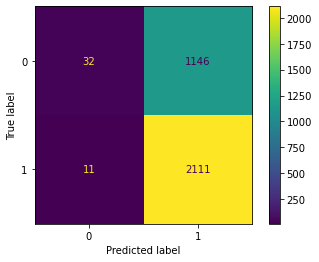

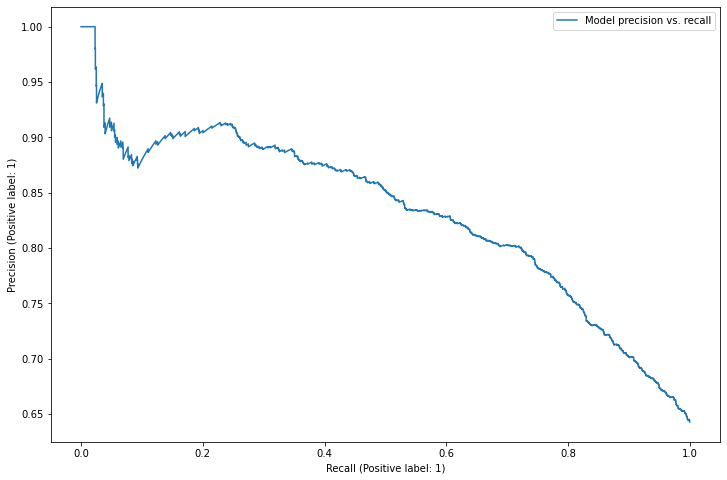

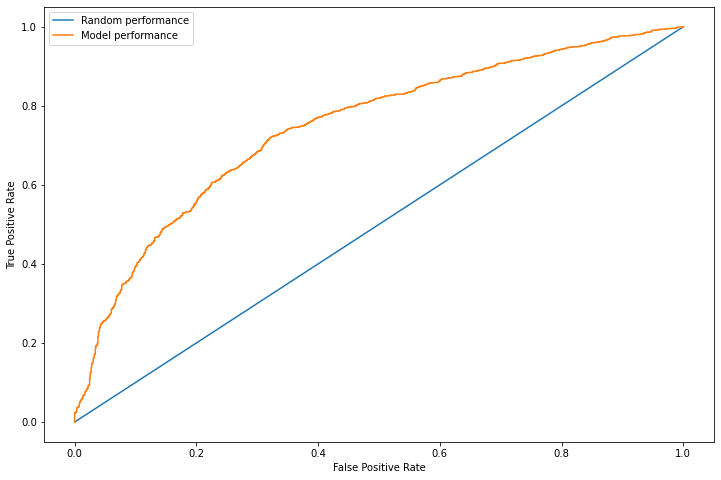

In [17]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [18]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Conv1D-SMOTEENN-Oversampling' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Conv1D-SMOTEENN-Oversampling20210602-2137


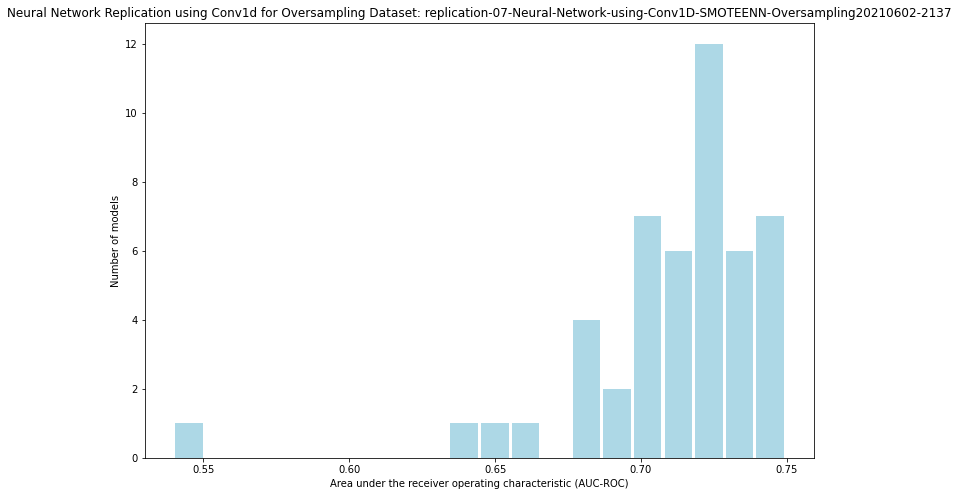

In [19]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Conv1d for Oversampling Dataset: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [20]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../DeepLearningResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)